# Dynamics of the perceptron 

Variables to fix 

1. $\alpha = \frac{M}{N}$ 
2. $\sigma$ = max credit limit 
3. $\eta$ = Var(budget) 
4. $\bar{p}$ = Average price of the goods 
5. $\Delta$ = $\bar{p^2} - \bar{p}$  :  Fluctuations of the prices around $\bar{p}$. 

A few other variables are required 

6. $\epsilon_{D}$ : Susceptibility of the demand to change based on the production 
7. $\epsilon_{p}$ : Susceptibility of the demand to changes of prices. 


# Basic equations 

We want to solve for $p_{i}$s via the following equation:

\begin{equation}
\dot{p_{i}} = -\frac{\partial H}{\partial p_{i}} - \frac{1}{\Delta} (p_{i} - \bar{p})(A-B\bar{p}) - B 
\end{equation}

where 

\begin{align} 
A & = -\frac{1}{N} \sum_{i}^{N} p_{i} \frac{\partial H}{\partial p_{i}} \\
B &= -\frac{1}{N} \sum_{i}^{N} \frac{\partial H}{\partial p_{i}} 
\end{align} 

We also report the expression for the first term above: 

\begin{equation}
\frac{\partial H}{\partial p_{i}} = \frac{1}{\sqrt{N}} \sum_{\mu}^{M} h_{\mu} \xi_{i}^{\mu} \theta(-h_{\mu})
\end{equation}

with 

\begin{equation}
h_{\mu} = \frac{1}{\sqrt{N}} \sum_{j}^{N} \xi_{j}^{\mu} p_{j} - \sigma - b_{\mu} 
\end{equation} 


In the code that follows, we use the machinery of vectorization available via numpy to facilitate the calculations and get appreciable speedups. 


In [1]:
# imports 

import numpy as np 
import scipy 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.integrate import quad 
from scipy.optimize import brentq, newton, ridder, bisect
%matplotlib inline 

In [2]:
def initialise(alpha, N,p_bar, Delta):
    M = int(alpha*N)
    return np.random.randn(int(M),N), np.random.normal(p_bar, np.sqrt(Delta),N)


In [3]:
def jamming_integrand(h,sigma, eta = 0.0):
    ''' Integrand which enters for the computation of the 
        jamming line'''
    den = 1.0/np.sqrt(2*np.pi*(1+eta))
    fun = np.exp(-(h*h)/(2*(1+eta)))
    fac = (h-sigma)**2
    return fun*fac*den

def standard_integrand(h, sigma, eta):
    ''' Integrand for the second integral entering 
        the computation for the UNSAT instability'''
    den = 1.0/np.sqrt(2*np.pi*(1+eta))
    fun = np.exp(-(h*h)/(2*(1+eta)))
    return den*fun
def func_to_solve_UNSAT(chi,m, sigma = 0.0):
    ''' Function to compute the value of '''
    return (1-m**2)*(quad(standard_integrand, -np.inf, chi, args = (chi, sigma))[0]) - quad(jamming_integrand, -np.inf, 
                                                                                            chi, args = (chi, sigma))[0]

def compute_chi(m, sigma = 0.0):
    return newton(func_to_solve_UNSAT, 0.0, args = (m, sigma), maxiter = 500)
#     return brentq(func_to_solve_UNSAT, -4.0, 3.0, args = (m, sigma))
    

def compute_alpha_J(sigma, m, eta = 0.0):
    ''' Computes a particular value on the jamming line 
        for a given value of chi and m'''
    integral = quad(jamming_integrand, -np.inf, sigma, args = (sigma,eta))
    return (1-m**2)/integral[0]    
    
def jamming_line(sigma_range, m, eta = 0.0):
    ''' Computes the jamming line for a range of values of chi'''
    alpha = []
    for sigma in sigma_range:
        integral = quad(jamming_integrand, -np.inf, sigma, args = (sigma, eta))
        alpha.append((1-m**2)/integral[0])
    return np.asarray(alpha)

In [20]:
def compute_rhs(N, xi_matrix, prices, sigma):
    h_mu = ((1.0/np.sqrt(N))*xi_matrix.dot(prices)) - sigma
    temp = np.multiply(h_mu, np.heaviside(-1.0*h_mu, 0.0))
    del_h = (1.0/np.sqrt(N))*temp.dot(xi_matrix)
    energy = 0.5*np.sum(np.square(np.multiply(h_mu, np.heaviside(-1.0*h_mu, 0.0))))
    energy = energy/N
    return del_h, energy

In [21]:
def compute_energy(N, xi_matrix, prices, sigma):
    h_mu = ((1.0/np.sqrt(N))*xi_matrix.dot(prices)) - sigma
    energy = 0.5*np.sum(np.square(np.multiply(h_mu, np.heaviside(-1.0*h_mu, 0.0))))
    energy = energy/N
    return energy

In [22]:
def loop(N, xi_matrix, prices, sigma, m, Delta, max_iter=100000, step_size = 1e-3, tol = 1e-5, tol_energy = 1e-7):
    converge = False
    energy_list = []
    norm_list = []
    iteration_number = 0
    while (converge != True) and iteration_number < max_iter:
        del_x, energy = compute_rhs(N, xi_matrix, prices, sigma)
        Y = prices - del_x*step_size
        Y[-1] = -1.0*np.sum(Y[:N-1])
        nu = np.sqrt(np.average(np.square(Y)))
        nu = nu/np.sqrt((1-m**2))
        Y = Y/nu
        diff = np.linalg.norm(Y - prices)
        temp_del_x, temp_energy = compute_rhs(N, xi_matrix, Y, sigma)
        energy_1 = compute_energy(N, xi_matrix, Y+m, sigma)
        energy_2 = compute_energy(N, xi_matrix, prices+m, sigma)
        if np.abs(energy_1-energy_2) < tol_energy:
            prices = Y 
            converge = True
        else:
            converge = diff < tol
            prices = Y 
        iteration_number +=1
        del_norm = np.linalg.norm(del_x)
        if (iteration_number %1000 == 0.0):
            print "Iteration number: {}".format(iteration_number)
            print "{}  {} {} {} {} {} ".format(energy, diff, temp_energy, np.abs(temp_energy-energy), del_norm, energy_2)
        energy_list.append(energy)
        norm_list.append(del_norm)
    final_energy = compute_energy(N, xi_matrix, prices+m, sigma)
    print "Final Energy: {}". format(final_energy)
    return energy_list, norm_list, prices, prices + np.ones(N)*m, final_energy

In [7]:
alpha = 10
N = 1000
M = alpha*N
p_bar = 0.0
if (p_bar!=0):
    Delta = 3*p_bar**2
else:
    Delta = 1.0
eta = 0.0
tol = 1e-5
p_bar = 0.5
Delta = 0.3
sigma = 0.5
# sigma = sigma*(np.sqrt(p_bar**2 + Delta))
m = p_bar/(np.sqrt(p_bar**2 + Delta))
# m = 0.5
print sigma, Delta, m
#Initialisations 
step_size = 1e-1
budgets = eta*np.random.randn(int(M))

0.5 0.3 0.674199862463


In [10]:
alpha = 5.0
p_bar = 0.5
Delta = 0.3
sigma = 0.5
# sigma = sigma*(np.sqrt(p_bar**2 + Delta))
m = p_bar/(np.sqrt(p_bar**2 + Delta))
# m = 0.5
print sigma, Delta, m

0.5 0.3 0.674199862463


In [49]:
def compute_energy_analytic(alpha, sigma, m):
    alpha_J = compute_alpha_J(sigma, m)
    energy_analytic = 0.50*(1-m**2)*(np.sqrt(alpha/alpha_J) - 1)**2
    return energy_analytic

# Test with N = 1000

Lets just write a routine to do it 

In [25]:
def test_for_n(alpha, N, nb_runs = 20):
    energies = []
    M = int(N*alpha)
    for i in range(nb_runs):
        print "Trial number: {}".format(i+1)
        xi_matrix, prices = initialise(alpha, N, m, 1)
        print xi_matrix.shape, prices.shape
        energy_list, norm_list, prices_converge, real_prices, final_energy = loop(N, xi_matrix, prices, sigma, m, Delta)
        energies.append(final_energy)
        print "Difference: {}".format(((final_energy-energy_analytic)/energy_analytic)*100)
    energies = np.asarray(energies)
    ## Some plots
    plt.plot(np.arange(nb_runs), energies, 'b', np.arange(nb_runs),
         np.ones(nb_runs)*energy_analytic, 'r',
         np.arange(nb_runs), np.ones(nb_runs)*np.average(energies), 'g')
    return energies, ((energies-energy_analytic)/energy_analytic)*100

In [16]:
energies_thousand, differences_thousand = test_for_n(alpha, 1000, nb_runs = 2)

Trial number: 1
(5000, 1000) (1000,)


NameError: global name 'budgets' is not defined

 Value of N: 10
Trial number: 1
(50, 10) (10,)
Iteration number: 1000
0.74359081824  0.000643285571849 0.743530489492 6.03287477151e-05 2.26347726831 1.33582538419 
Iteration number: 2000
0.723760139879  0.000135319948297 0.723755561944 4.57793473585e-06 2.03858336304 1.31068130059 
Iteration number: 3000
0.721500659256  4.52039999481e-05 0.721499615353 1.04390289479e-06 2.01815322749 1.30834402602 
Iteration number: 4000
0.72092321249  1.4778208333e-05 0.720922932196 2.80293479205e-07 2.01074013779 1.30737314578 
Final Energy: 1.30719787324
Difference: 9.92372046655
Trial number: 2
(50, 10) (10,)
Iteration number: 1000
0.860138813546  0.00131386547221 0.859881992771 0.000256820774985 3.56921186869 1.24927640242 
Iteration number: 2000
0.785400372258  0.000322825992561 0.785382870672 1.7501585802e-05 2.838817591 1.15929079602 
Final Energy: 1.15513055238
Difference: -2.86378937578
Trial number: 3
(50, 10) (10,)
Iteration number: 1000
1.63108134901  0.00125727253442 1.63092635893 0.0001

Iteration number: 8000
0.800101749419  1.78453720781e-05 0.80010176541 1.59905154673e-08 2.32570548954 1.62129480013 
Final Energy: 1.62096555827
Difference: 36.3087934593
Trial number: 21
(50, 10) (10,)
Iteration number: 1000
0.815433797209  0.000480778046404 0.815367985204 6.58120047257e-05 3.28629393949 1.69601054341 
Iteration number: 2000
0.787648818157  8.98554030414e-05 0.787638971431 9.84672557702e-06 3.08328764782 1.65915769734 
Iteration number: 3000
0.782678756086  2.07487427838e-05 0.782676619385 2.13670079596e-06 3.04549042883 1.65319477743 
Final Energy: 1.65227263571
Difference: 38.9414403592
Trial number: 22
(50, 10) (10,)
Iteration number: 1000
0.665475897505  0.00158869364587 0.665444134248 3.17632573258e-05 2.2584480517 1.79434516163 
Final Energy: 1.76098053699
Difference: 48.0828084703
Trial number: 23
(50, 10) (10,)
Iteration number: 1000
1.23551274005  0.000833454504513 1.23528756322 0.000225176834328 5.65644748622 1.8447942398 
Iteration number: 2000
1.116937173

Final Energy: 1.35572121122
Difference: 14.0041018306
Trial number: 11
(100, 20) (20,)
Iteration number: 1000
0.976216606322  0.000705748887245 0.976121114436 9.54918864517e-05 7.29257414504 1.62855970732 
Iteration number: 2000
0.948084063691  0.000117424688173 0.948078727239 5.3364516317e-06 7.04212989594 1.59766011469 
Iteration number: 3000
0.945025071512  3.215455331e-05 0.945023373197 1.69831478036e-06 7.02453386758 1.5943682888 
Iteration number: 4000
0.943963658097  1.046343005e-05 0.943963055961 6.02136090544e-07 7.01651272309 1.59329942008 
Final Energy: 1.59327467794
Difference: 33.9802365884
Trial number: 12
(100, 20) (20,)
Iteration number: 1000
0.86571347902  0.00462986488878 0.865657972489 5.55065314645e-05 4.57227906146 1.92692706408 
Iteration number: 2000
1.04087999142  0.00228567465396 1.04085430207 2.56893465167e-05 7.0263294029 2.0723190679 
Final Energy: 2.06180867914
Difference: 73.3797809357
Trial number: 13
(100, 20) (20,)
Iteration number: 1000
0.936176189743 

Iteration number: 4000
1.03680430969  0.000126790708058 1.03680873232 4.42263763589e-06 7.41978759705 2.04048005707 
Iteration number: 5000
1.04081634413  8.3739796266e-05 1.04081974031 3.39618498302e-06 7.47135898694 2.04579524145 
Iteration number: 6000
1.04369220286  5.16951758425e-05 1.0436947761 2.57323397679e-06 7.50695799844 2.04965677418 
Iteration number: 7000
1.04593009013  3.14529500686e-05 1.0459319556 1.86547246361e-06 7.53526233931 2.05278462294 
Iteration number: 8000
1.04744554113  1.90410898929e-05 1.047446739 1.19787148245e-06 7.55451868793 2.05489122915 
Iteration number: 9000
1.04839779297  1.14732678965e-05 1.04839853232 7.39351998957e-07 7.56660633219 2.05621123537 
Final Energy: 2.05647197383
Difference: 72.9310114607
Trial number: 28
(100, 20) (20,)
Iteration number: 1000
0.648204520745  0.00124322490042 0.648136225024 6.82957211456e-05 2.84286610809 1.45587877075 
Final Energy: 1.44751133119
Difference: 21.7228349275
Trial number: 29
(100, 20) (20,)
Iteration n

Iteration number: 2000
0.765640622794  0.00143966578613 0.765571143681 6.94791133866e-05 6.82473707346 1.50749110872 
Iteration number: 3000
0.731922874126  0.000578018772113 0.731911553296 1.13208303526e-05 5.94802607904 1.47976279078 
Iteration number: 4000
0.726855233743  0.00027888753475 0.726853308937 1.92480633554e-06 5.84735768187 1.47772965778 
Final Energy: 1.47769352533
Difference: 24.2608891425
Trial number: 15
(250, 50) (50,)
Iteration number: 1000
0.880834752017  0.00553173430092 0.880824244826 1.05071917023e-05 9.45581164088 1.71114084806 
Iteration number: 2000
0.847801196359  0.00176730298158 0.847771024424 3.01719345351e-05 8.23732946497 1.65948226968 
Iteration number: 3000
0.832612708881  0.000809287663901 0.83260598225 6.72663029544e-06 7.84378590145 1.64621063035 
Final Energy: 1.64561712503
Difference: 38.3817710769
Trial number: 16
(250, 50) (50,)
Iteration number: 1000
1.34889667386  0.000177168876609 1.34886773657 2.8937295252e-05 17.3954654359 1.88693978674 
F

Iteration number: 5000
0.665799316732  0.000234012585299 0.665797253783 2.06294869287e-06 5.57387429195 1.40685844741 
Iteration number: 6000
0.664108619334  0.000175507640388 0.664107227478 1.39185637538e-06 5.49228626484 1.40533178102 
Iteration number: 7000
0.662991581936  0.000135821502203 0.662990706721 8.75214816953e-07 5.44328555761 1.40442528596 
Iteration number: 8000
0.662291836233  0.000106090817287 0.662291281082 5.55151772774e-07 5.41592083184 1.4038697506 
Iteration number: 9000
0.661884685729  7.65714605951e-05 0.661884418869 2.66859766285e-07 5.3995497212 1.40355773582 
Iteration number: 10000
0.66169695298  5.65029813111e-05 0.661696822115 1.30865487336e-07 5.39276633141 1.40338201647 
Final Energy: 1.40331192703
Difference: 18.00605796
Trial number: 2
(500, 100) (100,)
Iteration number: 1000
1.0766441524  0.00148031811023 1.07652393404 0.000120218354956 17.1014881129 1.86496968158 
Iteration number: 2000
1.01848907638  0.000453564335697 1.01846143438 2.76420042524e-05

Final Energy: 1.44027356823
Difference: 21.114203405
Trial number: 15
(500, 100) (100,)
Iteration number: 1000
1.26529134562  0.00013252716738 1.26528152627 9.81935559108e-06 21.6162124756 1.8045967398 
Final Energy: 1.80228143527
Difference: 51.5558468608
Trial number: 16
(500, 100) (100,)
Iteration number: 1000
1.16545585732  6.61858914188e-05 1.16545229016 3.56716476091e-06 21.3013202617 1.7110365288 
Final Energy: 1.71030046294
Difference: 43.8210647766
Trial number: 17
(500, 100) (100,)
Iteration number: 1000
0.869971189015  0.0035426850221 0.869780307159 0.000190881855896 11.1593093201 1.6552155024 
Iteration number: 2000
0.752325073835  0.00326603755585 0.752252886812 7.21870229259e-05 7.88555952493 1.55612858529 
Final Energy: 1.54014457917
Difference: 29.5124675958
Trial number: 18
(500, 100) (100,)
Iteration number: 1000
0.884461347026  0.00538734978732 0.884392119102 6.9227923747e-05 13.1007209782 1.69014408473 
Final Energy: 1.66759039718
Difference: 40.2295279282
Trial num

Iteration number: 5000
0.801071922878  0.000606787145183 0.801058459014 1.34638641859e-05 23.5567152258 1.51804768982 
Iteration number: 6000
0.789478617183  0.000473406714656 0.789468754622 9.86256158175e-06 22.8100896488 1.50633899439 
Iteration number: 7000
0.781471278108  0.000332558266068 0.781465041401 6.23670731292e-06 22.2956778198 1.49817330944 
Iteration number: 8000
0.776375061924  0.000238293156699 0.776370823466 4.23845754149e-06 21.9758862509 1.49294930069 
Iteration number: 9000
0.772761884335  0.000176062962754 0.77275886475 3.01958510429e-06 21.7449559987 1.48923147274 
Iteration number: 10000
0.770235297381  0.000127267222264 0.770233219677 2.077703943e-06 21.5835786666 1.48664516009 
Iteration number: 11000
0.768471954245  9.37660734635e-05 0.768470455175 1.49907046099e-06 21.4710619194 1.48486278348 
Iteration number: 12000
0.767162303253  7.0684398403e-05 0.76716119155 1.11170245132e-06 21.3862953134 1.4835347002 
Iteration number: 13000
0.766224755332  5.222145724

Iteration number: 4000
0.911706570431  8.52194654822e-05 0.91170589417 6.76260946464e-07 29.9454716256 1.66767706882 
Iteration number: 5000
0.911281404386  3.5749462628e-05 0.911281147681 2.56704811408e-07 29.9355759652 1.6672742532 
Iteration number: 6000
0.911107928347  1.60671442104e-05 0.911107816797 1.115497682e-07 29.930768802 1.66710866936 
Final Energy: 1.667099344
Difference: 40.1882347208
Trial number: 13
(2500, 500) (500,)
Iteration number: 1000
1.00744626881  0.00274126405122 1.0073491022 9.71666045073e-05 34.7629881916 1.72201415289 
Iteration number: 2000
0.963425525213  0.000689501452421 0.963408037492 1.74877208804e-05 32.6441992239 1.67568135217 
Iteration number: 3000
0.95403974652  0.000222403112995 0.954035270454 4.47606509035e-06 32.2423140813 1.66586999002 
Iteration number: 4000
0.951397312887  8.09454332671e-05 0.951395825189 1.48769746855e-06 32.1356261389 1.66315937426 
Iteration number: 5000
0.950445607162  3.18156754096e-05 0.950445044497 5.62664402626e-07 

Iteration number: 2000
0.839719736039  0.00322226434858 0.839649043819 7.06922194891e-05 23.5339399467 1.59063401262 
Iteration number: 3000
0.799945077557  0.00148123529017 0.799928564249 1.65133085884e-05 21.4006718659 1.5496997358 
Iteration number: 4000
0.792085080571  0.000741911923492 0.792081383064 3.69750671692e-06 21.3021389487 1.54170461329 
Iteration number: 5000
0.787967649506  0.000498316849189 0.787962737554 4.91195214825e-06 21.1880604167 1.53775326418 
Iteration number: 6000
0.783408296317  0.000374084736135 0.783404359845 3.93647209063e-06 20.9536405705 1.53312258934 
Iteration number: 7000
0.780012787035  0.000278193161479 0.780009999605 2.78743023707e-06 20.782115571 1.52962804829 
Iteration number: 8000
0.777563935761  0.000209940284432 0.777561724304 2.2114578091e-06 20.6574085689 1.52708624611 
Iteration number: 9000
0.775564380886  0.000164156181746 0.775562596577 1.78430920728e-06 20.5494945708 1.52500487529 
Iteration number: 10000
0.774025046834  0.00012727114

Iteration number: 2000
1.04371287292  0.000386049127989 1.04370679826 6.07465364988e-06 53.2430563381 1.76844524283 
Iteration number: 3000
1.04053996136  9.54767908914e-05 1.04053848859 1.47276138662e-06 53.0755564316 1.76517874256 
Iteration number: 4000
1.03972510343  2.64728474159e-05 1.03972470627 3.97162303267e-07 53.0299002047 1.76433481102 
Final Energy: 1.76412860193
Difference: 48.347532746
Trial number: 4
(5000, 1000) (1000,)
Iteration number: 1000
0.810864373963  0.0122326524244 0.81067686526 0.000187508702672 29.9909086385 1.59448121811 
Iteration number: 2000
0.712455402052  0.00651051998973 0.712410640695 4.47613571223e-05 21.0130898921 1.48936419712 
Iteration number: 3000
0.685065722029  0.00484007217138 0.685048352407 1.73696224646e-05 18.6163442694 1.46207049776 
Final Energy: 1.45672473884
Difference: 22.4976006066
Trial number: 5
(5000, 1000) (1000,)
Iteration number: 1000
0.746452372493  0.0159215988738 0.746338800756 0.000113571737643 26.0369738685 1.50245966755 

Iteration number: 3000
0.68038870384  0.00308579433041 0.68038409643 4.60740940378e-06 20.8123732212 1.40891867276 
Final Energy: 1.40857450292
Difference: 18.4485938094
Trial number: 16
(5000, 1000) (1000,)
Iteration number: 1000
0.976590749556  0.0047482492523 0.976464576653 0.000126172902171 48.6129132182 1.72139769011 
Iteration number: 2000
0.910382865003  0.00152107624497 0.910351283213 3.15817897204e-05 43.8704565788 1.6527827732 
Iteration number: 3000
0.893413431628  0.000504298697232 0.89340585859 7.57303880261e-06 42.730287443 1.63542134005 
Iteration number: 4000
0.889325702461  0.000177145586671 0.889323871311 1.83115012609e-06 42.4976533461 1.63126550133 
Iteration number: 5000
0.888373974427  6.57067097742e-05 0.888373580695 3.93732076942e-07 42.4577801923 1.63030547826 
Final Energy: 1.6301274065
Difference: 37.0792234482
Trial number: 17
(5000, 1000) (1000,)
Iteration number: 1000
0.980190980183  0.00417702365135 0.980087414982 0.000103565200377 47.8032155304 1.7250370

(5000, 1000) (1000,)
Final Energy: 1.53274876679
Difference: 28.8905455219
Trial number: 28
(5000, 1000) (1000,)
Iteration number: 1000
0.822556070949  0.0149320506387 0.822274634001 0.000281436947225 32.8615414402 1.56826037963 
Iteration number: 2000
0.696405912667  0.00721378796911 0.696359282734 4.662993303e-05 20.7263655868 1.43054997802 
Iteration number: 3000
0.673334081284  0.00315504964483 0.67332380917 1.02721143282e-05 18.5358779071 1.40591923161 
Iteration number: 4000
0.666817197657  0.00215706673691 0.666813287715 3.90994253796e-06 17.927579609 1.39965245605 
Iteration number: 5000
0.664310867209  0.00159120291101 0.664309407401 1.45980806776e-06 17.7253608101 1.39745728083 
Final Energy: 1.39704835257
Difference: 17.4793470298
Trial number: 29
(5000, 1000) (1000,)
Iteration number: 1000
0.749922423458  0.0169151106401 0.749844136817 7.82866416834e-05 32.9231389935 1.51248539441 
Iteration number: 2000
0.678893108336  0.00553567466431 0.678838936163 5.41721728541e-05 22.0

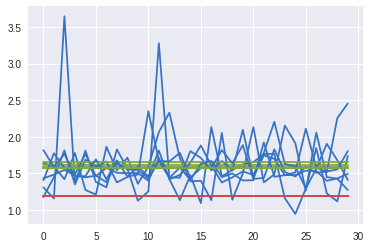

In [26]:
# Lets compute it for N=10, 20, 50, 100, 500, 1000 
Ns = [10,20, 50, 100, 500, 1000]
nb_runs = 30 
energy_list = []
differences_list = [] 
for N in Ns: 
    print " Value of N: {}".format(N)
    energies, differences = test_for_n(alpha, N, nb_runs)
    energy_list.append(energies)
    differences_list.append(differences)
    print "Average difference :{}".format(np.average(np.asarray(differences)))

Alpha : 1.0
Value of N:10
Trial number: 1
(10, 10) (10,)
Iteration number: 1000
0.142175422217  0.000832265008761 0.142098891574 7.65306430026e-05 1.01567763178 0.36409321279 
Iteration number: 2000
0.0885946286492  0.000508308080175 0.0885581294138 3.64992354493e-05 0.743158903474 0.307907297107 
Iteration number: 3000
0.0608093970449  0.000371628908017 0.0607881915259 2.12055189802e-05 0.587623765416 0.285619255674 
Iteration number: 4000
0.0436523689149  0.00030553833103 0.04363853104 1.38378748871e-05 0.475814510896 0.272439115454 
Iteration number: 5000
0.0321504820979  0.000268681157217 0.0321409919717 9.49012623142e-06 0.388511054433 0.262945529046 
Iteration number: 6000
0.0241888543824  0.000246606272567 0.0241822475733 6.60680909593e-06 0.318876214992 0.255800383124 
Iteration number: 7000
0.0186805095069  0.000233781172896 0.018676051323 4.45818383328e-06 0.26377705713 0.250573911417 
Iteration number: 8000
0.0151231447272  0.000239421806631 0.0151204511656 2.6935616393e-06 

Iteration number: 3000
0.0762436801497  0.000561054501538 0.0762408551937 2.82495595989e-06 1.04607666284 0.406221476827 
Iteration number: 4000
0.0750608981015  0.00028887942553 0.0750610457451 1.47643651846e-07 1.04544421525 0.393010058936 
Final Energy: 0.390926038513
Difference: -67.1265953989
Trial number: 7
(10, 10) (10,)
Iteration number: 1000
0.0335826075547  0.00104505977134 0.0335247859732 5.78215815703e-05 0.707055775351 0.158753718929 
Iteration number: 2000
0.0110250458504  0.000463444729448 0.0110156270641 9.41878631906e-06 0.342304702182 0.102911526711 
Iteration number: 3000
0.00486466060775  0.00027842574045 0.00486084554075 3.81506700583e-06 0.232255097867 0.0820127665796 
Iteration number: 4000
0.0023266269234  0.000180495132484 0.00232503264583 1.59427757141e-06 0.156999027803 0.0718068402083 
Iteration number: 5000
0.00124019448632  0.000121688010242 0.00123948469129 7.09795033519e-07 0.110038695286 0.0665203824161 
Iteration number: 6000
0.000739106900459  8.47518

Iteration number: 11000
0.000248653783372  3.37267083892e-05 0.000248573108336 8.06750350877e-08 0.035047200001 0.0590929129175 
Iteration number: 12000
0.000180464345  2.84365449163e-05 0.000180407189039 5.71559618248e-08 0.0298674103489 0.0588193235295 
Iteration number: 13000
0.000131910974189  2.40952216983e-05 0.000131870059347 4.09148416251e-08 0.0255428371598 0.0586106778516 
Iteration number: 14000
9.7005164284e-05  2.05029237353e-05 9.69756160604e-05 2.95482235963e-08 0.0219096085429 0.0584493025728 
Iteration number: 15000
7.17041001124e-05  1.75091342656e-05 7.16825991961e-05 2.15009163041e-08 0.0188409031607 0.058321665775 
Final Energy: 0.0582588210599
Difference: -95.1009510557
Trial number: 12
(10, 10) (10,)
Iteration number: 1000
0.146112164123  0.0016402308296 0.14604209784 7.00662830271e-05 1.09581953115 0.389254597822 
Iteration number: 2000
0.111424759766  0.00154251465082 0.111400163832 2.45959348895e-05 1.05022712036 0.362533100824 
Iteration number: 3000
0.084584

Iteration number: 7000
0.0188946014617  9.32904283367e-05 0.0188925915237 2.00993795741e-06 0.286276025579 0.16705916274 
Iteration number: 8000
0.0171289944105  7.81115726131e-05 0.0171274465946 1.54781592361e-06 0.271083462431 0.163975353801 
Iteration number: 9000
0.0157546218289  6.61498756959e-05 0.0157534034038 1.21842510554e-06 0.258711655202 0.161473254702 
Iteration number: 10000
0.0146624844075  5.659679234e-05 0.0146615067298 9.7767771548e-07 0.248483278536 0.159418496265 
Iteration number: 11000
0.0137789368291  4.88665343382e-05 0.0137781392245 7.97604583054e-07 0.239916523487 0.15771167186 
Iteration number: 12000
0.0130530143736  4.2530883479e-05 0.0130523543382 6.60035415739e-07 0.232661756087 0.156278884494 
Iteration number: 13000
0.0124486403303  3.72745589349e-05 0.0124480874279 5.52902367678e-07 0.226460281849 0.155064741431 
Iteration number: 14000
0.0119397238935  3.28637322772e-05 0.0119392558729 4.68020608933e-07 0.221117063994 0.154027277138 
Iteration number:

Iteration number: 5000
0.0698729840616  0.000119260098254 0.0698698035204 3.18054124802e-06 0.38055169465 0.188952953648 
Iteration number: 6000
0.0671902853186  9.12514207343e-05 0.0671880353594 2.24995919285e-06 0.372164329441 0.184137249907 
Iteration number: 7000
0.0652722489355  7.03906434553e-05 0.0652706251447 1.62379078721e-06 0.367230201997 0.180594597862 
Iteration number: 8000
0.0638591043137  5.5601095286e-05 0.0638578599841 1.2443295013e-06 0.365011207077 0.177971227086 
Iteration number: 9000
0.0627567395383  4.41393352283e-05 0.0627557686877 9.7085059933e-07 0.364227155659 0.176011385118 
Iteration number: 10000
0.061896635994  3.49966213127e-05 0.0618958776202 7.58373754496e-07 0.363750372657 0.174551875763 
Iteration number: 11000
0.0612236545694  2.77848726935e-05 0.0612230601314 5.94437994716e-07 0.363369998208 0.173457523942 
Iteration number: 12000
0.0606953682773  2.21042981714e-05 0.0606949009315 4.6734584775e-07 0.36304483623 0.172631904063 
Iteration number: 13

Iteration number: 8000
0.0356844244298  6.21475513338e-05 0.0356834400107 9.8441913423e-07 0.583815627599 0.101876051954 
Iteration number: 9000
0.0347712686826  5.4273275624e-05 0.0347704294207 8.39261893752e-07 0.575641504664 0.100757435845 
Iteration number: 10000
0.0340014263253  4.74760420279e-05 0.0340007216833 7.04642035249e-07 0.568906636317 0.0998003055272 
Iteration number: 11000
0.0333527380465  4.16482136588e-05 0.0333521411986 5.96847953442e-07 0.563274451793 0.0989923137784 
Iteration number: 12000
0.0328003880877  3.66362650826e-05 0.0327998772763 5.10811382082e-07 0.558465064839 0.0983063832987 
Iteration number: 13000
0.0323258725339  3.2302314649e-05 0.032325432182 4.40351928616e-07 0.554309711399 0.0977192309355 
Iteration number: 14000
0.031915770548  2.85360420656e-05 0.0319153890593 3.81488709941e-07 0.550699489386 0.0972133356554 
Iteration number: 15000
0.0315598047024  2.52500365855e-05 0.0315594729452 3.31757285935e-07 0.547552610718 0.0967753411955 
Iteration

Iteration number: 6000
0.0500498689366  0.000277725222505 0.0500435596682 6.30926836731e-06 0.514803308059 0.198404763672 
Iteration number: 7000
0.0452957981784  0.000196860448234 0.0452921893255 3.6088529745e-06 0.463378799453 0.194097399121 
Iteration number: 8000
0.0423243940871  0.000155307263106 0.042321903794 2.49029307881e-06 0.436828646209 0.19176168173 
Iteration number: 9000
0.0400846981785  0.000133561802854 0.0400826822705 2.01590802756e-06 0.414519130301 0.190008137197 
Iteration number: 10000
0.0382311255798  0.000120928018954 0.0382294108539 1.71472591583e-06 0.394137914079 0.188558632493 
Iteration number: 11000
0.0366217955654  0.000113345620366 0.0366202805908 1.51497459808e-06 0.375367066101 0.187316587381 
Iteration number: 12000
0.0351431220686  0.000112648055509 0.0351416457677 1.47630089595e-06 0.360513510076 0.185982497665 
Iteration number: 13000
0.0336669246257  0.000114648583672 0.0336654583283 1.46629742653e-06 0.34853699348 0.184247053286 
Iteration number

Iteration number: 10000
0.0158263718782  0.000203531097648 0.0158242306261 2.14125209102e-06 0.291086811242 0.143523900455 
Iteration number: 11000
0.01374014722  0.000272007836543 0.0137381769499 1.97027002546e-06 0.258054444013 0.14216249972 
Iteration number: 12000
0.0121122534077  0.000387690225944 0.0121111168575 1.13655025193e-06 0.279326819988 0.141003571645 
Final Energy: 0.140956933615
Difference: -88.146774956
Trial number: 7
(20, 20) (20,)
Iteration number: 1000
0.0689020832553  0.00103071097795 0.0688607464428 4.13368125276e-05 0.841883934525 0.354496547654 
Iteration number: 2000
0.0499928060107  0.000617398895675 0.0499828385696 9.96744103447e-06 0.487378983822 0.325475796991 
Iteration number: 3000
0.0423608893087  0.000642695433656 0.0423551971758 5.69213293983e-06 0.518591309346 0.308548556331 
Iteration number: 4000
0.0382115744131  0.00071952821808 0.0382088575763 2.7168367475e-06 0.582740410451 0.298994009893 
Final Energy: 0.297150419389
Difference: -75.0122913247


Iteration number: 5000
0.00593457462267  0.000302296211818 0.00593313199378 1.4426288896e-06 0.364092271469 0.154262412167 
Iteration number: 6000
0.00472163623609  0.000215679042372 0.00472064161106 9.94625029914e-07 0.302144013071 0.146964372969 
Iteration number: 7000
0.00390546873237  0.000164822380793 0.00390480979031 6.58942054501e-07 0.257024325485 0.142269580919 
Iteration number: 8000
0.00336468055334  0.000132986176288 0.00336424171849 4.38834843962e-07 0.226192297227 0.139135645203 
Iteration number: 9000
0.00300089831932  0.000111923208333 0.00300059914252 2.99176796981e-07 0.205449406591 0.136967685761 
Iteration number: 10000
0.0027494880033  9.72595658047e-05 0.00274927794961 2.10053688132e-07 0.191435761448 0.135419035662 
Iteration number: 11000
0.00257050921365  8.65172899058e-05 0.00257035740307 1.51810586741e-07 0.181828485597 0.134281725643 
Iteration number: 12000
0.00243955654837  7.82440194943e-05 0.00243944403888 1.12509490684e-07 0.175107533674 0.133427317316 

Iteration number: 6000
0.0161339590087  0.000192202890489 0.0161318557094 2.10329930021e-06 0.303539404429 0.08444153082 
Iteration number: 7000
0.0143367679476  0.000164448848573 0.0143352311326 1.53681502738e-06 0.276198484308 0.0816338336792 
Iteration number: 8000
0.0129915664749  0.000144271111384 0.0129903881483 1.17832661756e-06 0.255943608606 0.0794259313742 
Iteration number: 9000
0.0119412194977  0.000128624828171 0.0119402829255 9.3657220592e-07 0.241145415356 0.0776296071319 
Iteration number: 10000
0.0110967578812  0.00011560408628 0.0110959966297 7.61251453395e-07 0.230044885661 0.0761086818699 
Iteration number: 11000
0.0104035685148  0.00010491523116 0.0104029374185 6.31096359227e-07 0.220991120804 0.0748466183573 
Iteration number: 12000
0.00982436965362  9.5972992391e-05 0.00982383828036 5.31373259366e-07 0.213425865228 0.0737952289864 
Iteration number: 13000
0.00933369250195  8.83496850201e-05 0.0093332396226 4.52879349347e-07 0.206988383178 0.0729126960769 
Iterati

Iteration number: 4000
0.0210693384411  0.000182799169066 0.0210662944857 3.04395535411e-06 0.589120226525 0.138909806109 
Iteration number: 5000
0.0186089085587  0.000138502083646 0.0186069310505 1.97750820358e-06 0.559627954671 0.135142190258 
Iteration number: 6000
0.0169733998835  0.000108242022111 0.0169720578456 1.34203786229e-06 0.538081453894 0.132444379576 
Iteration number: 7000
0.0158502659885  8.63979316983e-05 0.0158493340928 9.31895663539e-07 0.522582201501 0.130482038767 
Iteration number: 8000
0.0150650170744  7.01116215577e-05 0.0150643612994 6.5577504197e-07 0.511557881291 0.129054431083 
Iteration number: 9000
0.0145102758645  5.76963674987e-05 0.0145098109662 4.64898252202e-07 0.503769895071 0.128023800799 
Iteration number: 10000
0.0141163519366  4.8061614841e-05 0.0141160214535 3.30483152729e-07 0.498302263543 0.127290446706 
Iteration number: 11000
0.0138364366883  4.04642848684e-05 0.0138362021442 2.34544075189e-07 0.494496365812 0.126780368481 
Iteration number

Iteration number: 8000
0.0304189689373  0.000138970548146 0.0304176848863 1.28405096514e-06 0.77404726417 0.151726885517 
Iteration number: 9000
0.0292921609187  0.000114538280329 0.0292911602323 1.00068641362e-06 0.7533043667 0.150776003786 
Iteration number: 10000
0.028385813721  9.66790930709e-05 0.028384990715 8.23005958633e-07 0.735366208356 0.150009092683 
Iteration number: 11000
0.0276490736147  8.11449072313e-05 0.027648421784 6.51830636671e-07 0.720431098467 0.149367719149 
Iteration number: 12000
0.0270744085884  6.73497351813e-05 0.0270739064416 5.02146838607e-07 0.709691652709 0.148847267294 
Iteration number: 13000
0.0266349399882  5.54257149587e-05 0.0266345586738 3.81314399365e-07 0.702562242542 0.148431153307 
Iteration number: 14000
0.0263031020906  4.53133492284e-05 0.0263028159208 2.86169756065e-07 0.698153319834 0.148101438849 
Iteration number: 15000
0.0260554504145  3.68661075421e-05 0.0260552381739 2.12240604792e-07 0.69569683175 0.147842493965 
Iteration number:

Iteration number: 3000
0.0534803950536  0.00066079839594 0.0534628754347 1.75196189204e-05 1.45818358456 0.173411658959 
Iteration number: 4000
0.0403465795344  0.000473008579797 0.040337056893 9.52264147454e-06 1.16081500668 0.161125773174 
Iteration number: 5000
0.0326448134501  0.00037572387456 0.0326385734421 6.2400079889e-06 0.982472357166 0.154360654181 
Iteration number: 6000
0.0276542466032  0.000281419681678 0.0276503949338 3.85166939649e-06 0.854940862684 0.150380652595 
Iteration number: 7000
0.0247640682904  0.000207495607065 0.0247618575493 2.21074105084e-06 0.759091516833 0.148476670678 
Iteration number: 8000
0.0228878807269  0.000174832116406 0.0228862437075 1.63701933791e-06 0.710438057644 0.147740498797 
Iteration number: 9000
0.0213814518695  0.000159659696077 0.0213800491011 1.40276848653e-06 0.669759355345 0.147466660065 
Final Energy: 0.147421591161
Difference: -87.6031547256
Trial number: 7
(50, 50) (50,)
Iteration number: 1000
0.149712540535  0.000730854708265 0

Iteration number: 11000
0.0117656586792  0.000119512940781 0.0117652500517 4.08627495467e-07 0.407506890567 0.139687533874 
Iteration number: 12000
0.0114142080691  9.85686713611e-05 0.0114139063901 3.01678981664e-07 0.404983481855 0.138968657041 
Iteration number: 13000
0.0111500199959  8.27659238845e-05 0.0111497884994 2.31496488095e-07 0.403672829067 0.138450615412 
Iteration number: 14000
0.0109433685294  7.06901375302e-05 0.0109431837045 1.84824910774e-07 0.402752166976 0.138067593199 
Iteration number: 15000
0.0107754793003  6.1302956687e-05 0.0107753264855 1.52814807924e-07 0.401851889676 0.137774827915 
Iteration number: 16000
0.0106347232537  5.38533854894e-05 0.0106345934121 1.29841568879e-07 0.400853832036 0.137542992983 
Iteration number: 17000
0.0105139205763  4.78053365268e-05 0.0105138080959 1.12480420544e-07 0.399756647833 0.137353343238 
Iteration number: 18000
0.0104085587378  4.2782172609e-05 0.0104084600267 9.87110813679e-08 0.398600388003 0.137194024806 
Iteration 

Iteration number: 13000
0.00198491898961  0.000106552502175 0.00198467158296 2.47406656433e-07 0.214015873516 0.0815793336918 
Iteration number: 14000
0.00176341383908  9.59946293889e-05 0.00176321567206 1.98167019403e-07 0.198711100451 0.0806099161618 
Iteration number: 15000
0.00158431716985  8.70334786045e-05 0.00158415552011 1.61649744472e-07 0.186132172609 0.0797802829701 
Iteration number: 16000
0.00143704654187  7.94471252107e-05 0.00143691240066 1.34141215806e-07 0.175649136758 0.0790649822903 
Iteration number: 17000
0.00131462308172  7.21548085267e-05 0.00131451149816 1.11583554649e-07 0.167093592862 0.0784471556278 
Iteration number: 18000
0.00121203262319  6.60087778455e-05 0.00121193827336 9.43498301743e-08 0.159993594906 0.0779138934974 
Iteration number: 19000
0.00112461635679  6.09045418696e-05 0.00112453534775 8.10090418901e-08 0.153804026061 0.0774462868488 
Iteration number: 20000
0.00104908798809  5.65917022279e-05 0.0010490175634 7.04246842132e-08 0.148292939539 0.

Iteration number: 6000
0.01497798146  0.000390478873962 0.0149758488082 2.13265174836e-06 0.431007199956 0.102533674735 
Iteration number: 7000
0.0132092951577  0.000327498578644 0.0132078377489 1.45740878956e-06 0.398540959895 0.100529001705 
Iteration number: 8000
0.0120282314375  0.00029779831397 0.0120272672117 9.64225886944e-07 0.384798880125 0.099420952443 
Iteration number: 9000
0.0112149683124  0.000280364128345 0.0112142883794 6.79933053456e-07 0.384832444944 0.0986817229019 
Iteration number: 10000
0.010643323505  0.000267289558404 0.0106428513653 4.72139698157e-07 0.390547908245 0.0982806980548 
Iteration number: 11000
0.010299593817  0.000260965984923 0.0102993798788 2.13938218006e-07 0.400612806533 0.0980358825807 
Iteration number: 12000
0.0101476751532  0.00023872491989 0.0101476087694 6.63838713808e-08 0.414653478863 0.0978213232427 
Final Energy: 0.0977925017843
Difference: -91.7765199516
Trial number: 26
(50, 50) (50,)
Iteration number: 1000
0.068319741797  0.00305542

Iteration number: 2000
0.0853952561481  0.00153200421007 0.0853585354828 3.6720665282e-05 2.48011552877 0.198898958659 
Iteration number: 3000
0.0540245712459  0.00164840419981 0.0539979963673 2.65748786018e-05 1.61327250989 0.165948617875 
Iteration number: 4000
0.0339486126314  0.00138138535931 0.033935044547 1.35680843426e-05 1.05677887818 0.141538079391 
Iteration number: 5000
0.0244229351967  0.00105983256542 0.0244162009083 6.73428839323e-06 0.810527118593 0.127846882291 
Iteration number: 6000
0.0192423861033  0.000858829349672 0.0192384424846 3.94361868839e-06 0.706959540493 0.119354143825 
Iteration number: 7000
0.0161314616337  0.000674703508486 0.0161290608626 2.40077115721e-06 0.628107077992 0.113514404434 
Iteration number: 8000
0.0142140972185  0.000526806050668 0.014212571852 1.52536642884e-06 0.571728201673 0.109333822481 
Iteration number: 9000
0.0129702136172  0.000378381926989 0.0129692158596 9.97757552565e-07 0.522337962558 0.106218472458 
Iteration number: 10000
0.

Iteration number: 7000
0.00935820266838  0.000317844470912 0.00935758978028 6.12888106934e-07 0.51094776678 0.130617131286 
Iteration number: 8000
0.00883474825122  0.000283936204533 0.00883430590422 4.42346993904e-07 0.494594454736 0.129983880044 
Iteration number: 9000
0.00844936806789  0.000258535732638 0.00844903320851 3.34859380259e-07 0.484797383401 0.12964045064 
Iteration number: 10000
0.0081593863246  0.000241318862631 0.00815914815393 2.38170677586e-07 0.47914718822 0.129459504338 
Iteration number: 11000
0.00795561975987  0.000225240561003 0.00795544239302 1.77366857528e-07 0.477958574208 0.129290309901 
Final Energy: 0.129174016839
Difference: -89.1376135096
Trial number: 7
(100, 100) (100,)
Iteration number: 1000
0.0858889075583  0.00175674010258 0.0858340321612 5.48753971312e-05 3.32030941161 0.243051561789 
Iteration number: 2000
0.0542037125319  0.000857252195643 0.0541851440651 1.85684667531e-05 2.3790809747 0.211514444743 
Iteration number: 3000
0.0410049731324  0.000

Iteration number: 5000
0.0233020070078  0.000884006704949 0.0233005737814 1.43322639461e-06 1.30145888576 0.158199872424 
Final Energy: 0.158158631176
Difference: -86.7002651101
Trial number: 12
(100, 100) (100,)
Iteration number: 1000
0.0622226822246  0.00348280047051 0.0621460191043 7.66631202335e-05 2.26341718224 0.18911608106 
Iteration number: 2000
0.0260526925189  0.00246129454514 0.0260390663728 1.36261460841e-05 1.26519300972 0.134547303493 
Iteration number: 3000
0.0178570836621  0.00173669402049 0.017852434966 4.64869610237e-06 1.12567443447 0.117098694376 
Iteration number: 4000
0.0146844720361  0.00133416007289 0.0146822755795 2.19645657406e-06 0.988612902629 0.110540626373 
Iteration number: 5000
0.013086162706  0.000924328015816 0.0130849618605 1.20084552488e-06 0.907693716582 0.108245358833 
Iteration number: 6000
0.0120116869012  0.000677323683086 0.0120107723962 9.14505034741e-07 0.832260782493 0.10601991576 
Iteration number: 7000
0.011251364406  0.000580098664584 0.0

Iteration number: 10000
0.0344370683463  9.9786392786e-05 0.0344363231507 7.45195574865e-07 1.27981314472 0.17038784474 
Iteration number: 11000
0.0337683894178  8.31555732739e-05 0.0337677919073 5.97510458986e-07 1.26488000956 0.169535222508 
Iteration number: 12000
0.033230988043  6.96568796738e-05 0.0332305062114 4.81831628422e-07 1.25327475664 0.168853169377 
Iteration number: 13000
0.0327964249562  5.86117373999e-05 0.0327960341388 3.90817379653e-07 1.24407096338 0.168305469805 
Iteration number: 14000
0.032442896914  4.95013843348e-05 0.0324425779517 3.18962322506e-07 1.2367250544 0.167863388478 
Iteration number: 15000
0.0321535230541  4.19365867697e-05 0.0321532611741 2.61879973415e-07 1.23081554823 0.167504410819 
Iteration number: 16000
0.0319152975058  3.56181833227e-05 0.0319150813162 2.16189666932e-07 1.22602457762 0.167211131997 
Iteration number: 17000
0.0317181610569  3.03149042254e-05 0.0317179817125 1.79344322226e-07 1.22211249111 0.166970142377 
Iteration number: 180

Iteration number: 6000
0.0164323681781  0.000857758292093 0.0164302419128 2.12626534313e-06 0.820453015861 0.147510570311 
Iteration number: 7000
0.0147121553437  0.000715919538891 0.0147107875526 1.36779109126e-06 0.794119219179 0.145154385197 
Iteration number: 8000
0.0135081401097  0.00055286138357 0.0135069425274 1.19758227723e-06 0.755178942014 0.143568755544 
Iteration number: 9000
0.0124385452305  0.000405296783638 0.0124376298123 9.15418149575e-07 0.678416384441 0.142873766993 
Final Energy: 0.142714025103
Difference: -87.999019182
Trial number: 24
(100, 100) (100,)
Iteration number: 1000
0.0413407402896  0.00531745306014 0.0413076903442 3.30499453986e-05 2.43115715978 0.202879178579 
Final Energy: 0.178855854072
Difference: -84.9598126578
Trial number: 25
(100, 100) (100,)
Iteration number: 1000
0.0947468269985  0.0019272861124 0.0946857688907 6.10581077515e-05 3.31585744982 0.258731732603 
Iteration number: 2000
0.0602499407372  0.000942690570345 0.0602309331293 1.90076078715

Iteration number: 2000
0.0286088451057  0.00158750015664 0.0285961769089 1.26681967591e-05 1.26892697064 0.202056092829 
Iteration number: 3000
0.0201851446486  0.00110416559647 0.0201795835201 5.56112853317e-06 0.960675066615 0.185962825454 
Iteration number: 4000
0.0161367782068  0.000908100413633 0.016133898879 2.87932783329e-06 0.822688959068 0.178011530028 
Iteration number: 5000
0.0139134311928  0.0007567434463 0.013911745663 1.68552976292e-06 0.757404044203 0.174003586889 
Iteration number: 6000
0.0128154449486  0.000747100743568 0.0128148434643 6.01484293219e-07 0.756864052182 0.171578090652 
Iteration number: 7000
0.0124630465031  0.000702462773696 0.0124628786305 1.67872674829e-07 0.786281050266 0.16978225231 
Iteration number: 8000
0.0123708596124  0.000590455057688 0.0123708263338 3.32786006408e-08 0.793003510112 0.169063624724 
Final Energy: 0.169058485237
Difference: -85.7836842805
Trial number: 30
(100, 100) (100,)
Iteration number: 1000
0.0583199323769  0.00272591688533

Iteration number: 15000
0.0339320828181  3.52284642746e-05 0.0339319688136 1.14004464695e-07 3.44913991463 0.146082173702 
Final Energy: 0.146047488378
Difference: -87.7187045542
Trial number: 4
(500, 500) (500,)
Iteration number: 1000
0.113806603833  0.00666401527018 0.113690704233 0.000115899600049 8.87342657041 0.275003595212 
Iteration number: 2000
0.0470393759862  0.00460605585193 0.0470030870915 3.62888946066e-05 3.98409207191 0.198787015972 
Iteration number: 3000
0.0245260455625  0.00368157819811 0.0245132907424 1.27548200967e-05 2.25300596802 0.167738683778 
Iteration number: 4000
0.0165822663245  0.00386474644034 0.0165782302088 4.03611574659e-06 2.03243853481 0.15350771669 
Final Energy: 0.148724478539
Difference: -87.4935934795
Trial number: 5
(500, 500) (500,)
Iteration number: 1000
0.0791652896637  0.00596027571101 0.0791009318258 6.43578378561e-05 5.43216042723 0.212555330943 
Iteration number: 2000
0.0438468734778  0.00330795006862 0.0438264386608 2.04348170399e-05 3.13

Iteration number: 30000
0.00908165093459  0.000121679082279 0.00908148560255 1.65332038126e-07 1.32128051906 0.117698075644 
Iteration number: 31000
0.00892255895734  0.000115684432493 0.00892240591041 1.53046930915e-07 1.30564043461 0.117389898172 
Iteration number: 32000
0.00877516458696  0.000110016050918 0.00877502268058 1.41906377458e-07 1.29115388681 0.11710548176 
Iteration number: 33000
0.00863840844841  0.000104640808773 0.00863827669999 1.31748421513e-07 1.27771541512 0.116842588489 
Iteration number: 34000
0.00851137135327  9.95330016154e-05 0.008511248902 1.22451265615e-07 1.26523662244 0.116599378165 
Iteration number: 35000
0.00839324249185  9.46724882209e-05 0.00839312857366 1.13918190905e-07 1.25364005737 0.116374243527 
Iteration number: 36000
0.00828110495965  9.20296564384e-05 0.00828099402792 1.10931729344e-07 1.24197078917 0.116157397639 
Iteration number: 37000
0.00817243727744  8.91886023322e-05 0.00817233176696 1.05510481139e-07 1.23006061942 0.115943110686 
Ite

Iteration number: 2000
0.041384491307  0.00380341483001 0.0413588883088 2.56029981232e-05 3.41302940702 0.197504348097 
Iteration number: 3000
0.0241654626702  0.0033726887658 0.0241542123507 1.12503194299e-05 2.12661785798 0.170705113081 
Iteration number: 4000
0.0165235534426  0.00309063702912 0.0165186173946 4.93604794733e-06 1.90969159429 0.154426104143 
Iteration number: 5000
0.012983204619  0.00239460702541 0.0129805406814 2.66393762968e-06 1.86613456636 0.145157471645 
Iteration number: 6000
0.0107261002382  0.00168435713794 0.0107242970507 1.80318743111e-06 1.64763216094 0.139958803337 
Iteration number: 7000
0.00920217227569  0.00129197472623 0.0092009298047 1.24247099331e-06 1.45731865724 0.136879813558 
Iteration number: 8000
0.00818402996356  0.00110703973487 0.0081832017232 8.28240363297e-07 1.33901169313 0.135028081854 
Iteration number: 9000
0.00752479409475  0.00100890248812 0.00752428854204 5.05552712765e-07 1.27797008009 0.133905201404 
Iteration number: 10000
0.00713

Iteration number: 9000
0.00804724982377  0.00110850345926 0.00804675497249 4.94851282257e-07 1.14640938931 0.115414709347 
Iteration number: 10000
0.00767074215278  0.00105561116753 0.00767048566683 2.56485951654e-07 1.1635704608 0.114464878281 
Iteration number: 11000
0.00751060499147  0.00102321153441 0.00751052981082 7.5180651901e-08 1.19166133203 0.113799103207 
Iteration number: 12000
0.00754465750515  0.00104134105379 0.00754480419845 1.46693298687e-07 1.2435892577 0.113403225824 
Final Energy: 0.113348128829
Difference: -90.4684300029
Trial number: 20
(500, 500) (500,)
Iteration number: 1000
0.127846322348  0.00354714066487 0.127782925267 6.33970815172e-05 9.66179398899 0.267025214068 
Iteration number: 2000
0.0941719735322  0.00135675810802 0.0941546720689 1.73014633134e-05 7.64708078513 0.232855120226 
Iteration number: 3000
0.0828538538069  0.000668033430176 0.082846714696 7.1391108552e-06 7.01815437945 0.221319814039 
Iteration number: 4000
0.077884805538  0.000355434775944 

Iteration number: 7000
0.0109995344042  0.000525719203932 0.0109989161583 6.1824584195e-07 1.11127389833 0.119438815441 
Iteration number: 8000
0.0104916261385  0.000419272793752 0.0104912166659 4.09472515979e-07 1.10176758109 0.118857973158 
Iteration number: 9000
0.0101396827659  0.000348639003855 0.0101393670099 3.15756023534e-07 1.1014035681 0.118561055028 
Iteration number: 10000
0.00984060530986  0.000308087673398 0.00984032798926 2.77320602395e-07 1.09433774955 0.118286866032 
Iteration number: 11000
0.00958303579361  0.000275365453805 0.00958279849755 2.37296061046e-07 1.08566685192 0.118021802939 
Iteration number: 12000
0.00936341644729  0.000246756458467 0.00936321123005 2.05217238569e-07 1.07774605326 0.117791890103 
Iteration number: 13000
0.00916923974041  0.000225641893665 0.00916905754024 1.82200161371e-07 1.06853403155 0.117579864968 
Iteration number: 14000
0.00899962037448  0.000204051519199 0.00899946624672 1.54127766014e-07 1.06045467295 0.117394929914 
Iteration n

Iteration number: 16000
0.014953799966  0.000178831942568 0.0149534525629 3.47403098478e-07 1.81478149597 0.153997965092 
Iteration number: 17000
0.014627133867  0.000162794516845 0.0146268267588 3.07108146604e-07 1.79114451278 0.153477661169 
Iteration number: 18000
0.0143375875146  0.000148570904152 0.0143373146202 2.72894451777e-07 1.77013700092 0.153016402841 
Iteration number: 19000
0.0140786941318  0.000136391435615 0.0140784478573 2.46274559667e-07 1.75118255589 0.152603252409 
Iteration number: 20000
0.01385540238  0.00012042225869 0.0138551990358 2.03344150445e-07 1.73605520437 0.152244909541 
Iteration number: 21000
0.0136651640752  0.000108698373883 0.013664983372 1.80703178958e-07 1.72377855696 0.151939967945 
Iteration number: 22000
0.013490323806  0.000100520956072 0.0134901544235 1.69382549228e-07 1.71045812772 0.151649945344 
Iteration number: 23000
0.0133268448543  9.35213630623e-05 0.0133266881825 1.56671775196e-07 1.69709707772 0.151370111372 
Iteration number: 24000

Iteration number: 8000
0.024554295378  0.000294124044418 0.0245534473611 8.48016932908e-07 2.57894431428 0.134125552779 
Iteration number: 9000
0.0238164217759  0.000233951926841 0.0238157776062 6.44169715572e-07 2.55211833039 0.133123811551 
Iteration number: 10000
0.0232404824959  0.000191507283912 0.0232399675641 5.14931768655e-07 2.52843480812 0.132351010999 
Iteration number: 11000
0.022776495843  0.000159081903201 0.0227760788871 4.16955895505e-07 2.507371323 0.131731123287 
Iteration number: 12000
0.0224024802264  0.000131528249393 0.0224021505625 3.29663820207e-07 2.49014559274 0.131235654468 
Iteration number: 13000
0.0221201350354  0.00010602951009 0.0221198920689 2.42966466137e-07 2.47854451723 0.130877765811 
Iteration number: 14000
0.0218974154962  8.92590529296e-05 0.0218972102306 2.05265637529e-07 2.46896836734 0.130604999246 
Iteration number: 15000
0.021706971579  7.63186055804e-05 0.021706795234 1.76345010247e-07 2.45955673921 0.130371012648 
Iteration number: 16000
0

Iteration number: 48000
0.0148758377516  5.09417650416e-05 0.0148757450998 9.2651733773e-08 2.79992200677 0.142309826986 
Iteration number: 49000
0.0147822022274  5.19449774089e-05 0.0147821071904 9.50370051319e-08 2.78580731453 0.142150335933 
Iteration number: 50000
0.0146858843852  5.33043459633e-05 0.0146857868685 9.75167481904e-08 2.77091995402 0.141986041748 
Iteration number: 51000
0.0145875491903  5.41245709651e-05 0.0145874510085 9.81818268388e-08 2.7555445603 0.141818061065 
Iteration number: 52000
0.0144919812817  5.26437445892e-05 0.0144918883148 9.29669225543e-08 2.74103089831 0.141653780847 
Iteration number: 53000
0.0144015123896  5.08344396331e-05 0.0144014245391 8.78505337087e-08 2.72776074111 0.14149766239 
Iteration number: 54000
0.0143165298684  4.8546666513e-05 0.0143164477711 8.20972597317e-08 2.71565208438 0.141350601826 
Iteration number: 55000
0.0142370445062  4.62391172847e-05 0.0142369676788 7.68274062857e-08 2.70455405111 0.141212804107 
Iteration number: 56

Iteration number: 24000
0.0171584330295  8.53971237344e-05 0.0171582859998 1.47029685097e-07 3.04053884086 0.144823862405 
Iteration number: 25000
0.0170191293551  7.72360700721e-05 0.017018998278 1.31077113406e-07 3.02501036893 0.144602706384 
Iteration number: 26000
0.0168954739888  6.98070109693e-05 0.0168953571743 1.16814451057e-07 3.01137476824 0.144405462805 
Iteration number: 27000
0.0167851362353  6.308817533e-05 0.0167850321559 1.0407940117e-07 2.99925234678 0.14422904879 
Iteration number: 28000
0.0166868148654  5.69973501191e-05 0.0166867220788 9.27866311284e-08 2.98852957595 0.144071822486 
Iteration number: 29000
0.0165991158708  5.14923693436e-05 0.016599033067 8.28037787191e-08 2.97902195901 0.143931623359 
Iteration number: 30000
0.0165208212619  4.65151517068e-05 0.0165207473099 7.39519749604e-08 2.97057809947 0.143806514875 
Iteration number: 31000
0.0164508756566  4.2013189016e-05 0.0164508095719 6.60847194398e-08 2.96307166752 0.143694811325 
Final Energy: 0.1436459

Iteration number: 17000
0.0184925519588  0.00014566790212 0.0184923289582 2.23000657319e-07 2.87536897805 0.152741688598 
Iteration number: 18000
0.0182847898016  0.000129379814946 0.0182845965503 1.93251268439e-07 2.85658146092 0.152457459798 
Iteration number: 19000
0.0181024263844  0.000116535964221 0.0181022526552 1.73729264353e-07 2.83984993423 0.152206381611 
Iteration number: 20000
0.0179370425522  0.000105284617128 0.0179368871255 1.55426626822e-07 2.82376960246 0.151973869898 
Iteration number: 21000
0.0177904146132  9.32285426904e-05 0.0177902828464 1.31766781784e-07 2.80968016725 0.151765003853 
Iteration number: 22000
0.0176760874113  7.86118060524e-05 0.017675985497 1.01914275769e-07 2.80138570335 0.151601551566 
Iteration number: 23000
0.0175822273352  6.83021015179e-05 0.0175821408137 8.65215112229e-08 2.79496711131 0.151467070826 
Iteration number: 24000
0.0175020817974  5.96845177817e-05 0.017502007647 7.41503707012e-08 2.78937948635 0.151351989312 
Final Energy: 0.151

Iteration number: 12000
0.00644409498248  0.00144001291082 0.00644377419543 3.20787049829e-07 1.54356207889 0.124304575309 
Iteration number: 13000
0.00618673548407  0.00133481934193 0.00618655278187 1.82702204719e-07 1.5775632535 0.123474423716 
Final Energy: 0.123145212845
Difference: -89.6445823309
Trial number: 15
(1000, 1000) (1000,)
Iteration number: 1000
0.0759469440617  0.0108004598965 0.0758626221569 8.43219048633e-05 7.94566333011 0.204433127669 
Iteration number: 2000
0.0354694513899  0.00488090381484 0.0354516525089 1.77988809851e-05 3.89431896734 0.14832189924 
Iteration number: 3000
0.0240655071703  0.00288131018354 0.0240581911915 7.3159787982e-06 2.79406056401 0.131711452893 
Iteration number: 4000
0.0185016198746  0.00224808674397 0.0184973070605 4.31281406484e-06 2.28736187922 0.123713156822 
Iteration number: 5000
0.0149668889872  0.00193757906655 0.0149639918517 2.89713550256e-06 1.98490968688 0.118307438552 
Iteration number: 6000
0.0125127393762  0.00180605589382 

Iteration number: 18000
0.00657797753282  0.000295809099063 0.00657781622532 1.61307501e-07 1.34651088698 0.120288030322 
Iteration number: 19000
0.0064250991797  0.000278238828816 0.00642495393935 1.45240353982e-07 1.32882513701 0.120147123529 
Iteration number: 20000
0.00628339772227  0.000273200280506 0.00628325775517 1.39967093729e-07 1.30993646045 0.120003936833 
Iteration number: 21000
0.00614880865652  0.000263893685045 0.00614867981419 1.28842330781e-07 1.29059426423 0.119843937171 
Iteration number: 22000
0.00602140891673  0.000262017229891 0.00602128544272 1.23474005337e-07 1.27124295117 0.119671488479 
Iteration number: 23000
0.00590297164849  0.000253065983916 0.00590285870909 1.12939400991e-07 1.253605845 0.119499882346 
Iteration number: 24000
0.00579505099498  0.000243518793667 0.00579494776324 1.03231743186e-07 1.23805628382 0.119347838004 
Iteration number: 25000
0.00569620852128  0.00023431690857 0.00569611386683 9.46544524722e-08 1.2240931086 0.119213312682 
Iteratio

Iteration number: 8000
0.0100387430444  0.00163764991674 0.0100381127287 6.30315718691e-07 2.10494065503 0.129271738331 
Iteration number: 9000
0.00955810993352  0.00143044700787 0.00955774123832 3.68695193723e-07 2.01741966808 0.128727315736 
Iteration number: 10000
0.0092303191058  0.00119621778231 0.0092300062004 3.12905402053e-07 1.94667640197 0.128528023432 
Final Energy: 0.128492848138
Difference: -89.1948937419
Trial number: 25
(1000, 1000) (1000,)
Iteration number: 1000
0.180382064499  0.00302839866437 0.180333177253 4.88872461594e-05 18.3216600178 0.320118962106 
Iteration number: 2000
0.155518694694  0.000850146913139 0.155507276159 1.14185346599e-05 16.4886638176 0.295019845231 
Iteration number: 3000
0.14895867345  0.000279067827802 0.148955305565 3.36788591968e-06 16.0378373953 0.288310278201 
Iteration number: 4000
0.146967391192  9.51370792905e-05 0.146966324039 1.06715271422e-06 15.9096244304 0.286256597169 
Iteration number: 5000
0.146333685779  3.2419682034e-05 0.1463

Iteration number: 8000
0.0165978634724  0.00125291429493 0.0165954301309 2.43334144418e-06 2.41276484185 0.139354183223 
Iteration number: 9000
0.0143827278447  0.00124909941173 0.0143806957885 2.0320561438e-06 2.11802555386 0.135486998921 
Iteration number: 10000
0.01250918122  0.00128069005726 0.0125074658213 1.71539868222e-06 1.87056899401 0.131970073188 
Iteration number: 11000
0.0109765045167  0.00124076858977 0.0109751519878 1.35252896828e-06 1.68390307573 0.128914777968 
Iteration number: 12000
0.00978732697939  0.00116527487646 0.00978627885843 1.04812095784e-06 1.55687148842 0.126454716348 
Iteration number: 13000
0.00884085097708  0.00118664407522 0.00884000070357 8.50273516536e-07 1.47178439298 0.12436268287 
Iteration number: 14000
0.00808104672376  0.00119973035743 0.00808037322668 6.73497070445e-07 1.42492377759 0.12249872914 
Iteration number: 15000
0.0074909817485  0.00123473824551 0.00749047676121 5.04987286734e-07 1.41125291982 0.120919803883 
Iteration number: 16000


Iteration number: 1000
1.21652293692  0.0018742606482 1.21632255268 0.000200384238085 4.93982134324 2.29286003098 
Iteration number: 2000
1.06543791594  0.000881991304296 1.06535811847 7.9797474575e-05 3.8498148013 2.00038772142 
Iteration number: 3000
1.00900216672  0.000731528502231 1.00896173537 4.04313507465e-05 3.69561721762 1.86769266049 
Final Energy: 1.83537947054
Difference: 54.3390973936
Trial number: 14
(50, 10) (10,)
Iteration number: 1000
1.68346386689  0.00193274858045 1.68281436554 0.000649501352938 8.41126507729 2.48629229094 
Iteration number: 2000
1.27436971608  0.00112368399165 1.27409817798 0.000271538093807 5.91304763185 2.12307943226 
Iteration number: 3000
1.03728676916  0.00105751095217 1.03706109685 0.000225672314457 4.64614242256 1.94438787556 
Iteration number: 4000
0.846318734148  0.00122061427682 0.846167726084 0.000151008064131 3.42132836674 1.84762344098 
Final Energy: 1.84644147042
Difference: 55.2693132443
Trial number: 15
(50, 10) (10,)
Iteration numbe

Final Energy: 1.45587419605
Difference: 22.4260775189
Trial number: 27
(50, 10) (10,)
Iteration number: 1000
1.10491661062  0.00199578446111 1.10479036021 0.000126250413246 4.23176287494 1.99302262492 
Iteration number: 2000
1.07644476131  0.000614720194647 1.07643631673 8.44457889415e-06 4.25777701634 1.89501929836 
Final Energy: 1.89307487817
Difference: 59.1907682765
Trial number: 28
(50, 10) (10,)
Iteration number: 1000
1.17002928533  0.00256699365697 1.16867589943 0.00135338590597 7.31885055672 1.42473364695 
Iteration number: 2000
0.536218200572  0.000567077387045 0.536110769477 0.00010743109487 2.60959012414 0.853148007591 
Iteration number: 3000
0.505037111287  9.8466733474e-05 0.505032827784 4.28350323678e-06 2.27496371434 0.816237633971 
Iteration number: 4000
0.503449755884  3.35595564951e-05 0.503449092862 6.63022650116e-07 2.27143233351 0.814680122685 
Iteration number: 5000
0.502927763515  1.40866160477e-05 0.502927356344 4.07171243277e-07 2.26994436323 0.81413513923 
Fin

Iteration number: 1000
1.04282216921  0.001977651446 1.04264583597 0.000176333235664 5.87838662681 1.78912982712 
Final Energy: 1.74397526336
Difference: 46.6528161307
Trial number: 17
(100, 20) (20,)
Iteration number: 1000
0.673583411527  0.00318502163512 0.673557369371 2.60421560593e-05 3.76354743814 1.45920082708 
Iteration number: 2000
0.738968127914  0.000993528581362 0.738916229737 5.18981767738e-05 5.22990781836 1.58460648144 
Iteration number: 3000
0.647951250772  0.00062140929647 0.647890153833 6.10969392538e-05 3.27206394551 1.4543211072 
Final Energy: 1.42292570611
Difference: 19.6554024188
Trial number: 18
(100, 20) (20,)
Iteration number: 1000
1.02967045925  0.0027696950406 1.02941151718 0.000258942071091 5.80364844756 2.05603577209 
Iteration number: 2000
0.960533610183  0.0024106726083 0.960414705672 0.000118904511221 5.74501410512 1.95605960684 
Iteration number: 3000
0.846235433411  0.00134597254346 0.846170388524 6.5044887009e-05 4.27248112209 1.81491138247 
Iteration

Iteration number: 2000
0.923727322386  0.000623576398874 0.923670037169 5.72852162691e-05 9.15508772647 1.69770489575 
Iteration number: 3000
0.888551964384  0.000244283510592 0.88853329165 1.86727344419e-05 8.47879811395 1.66408051203 
Iteration number: 4000
0.877592722787  9.34720681481e-05 0.877586546924 6.17586309914e-06 8.26784310355 1.6538256872 
Iteration number: 5000
0.873544675215  4.14243966862e-05 0.873542159919 2.51529590001e-06 8.19096828005 1.650111328 
Iteration number: 6000
0.871866512707  1.94984207041e-05 0.871865466664 1.04604280737e-06 8.15961091415 1.64855637459 
Final Energy: 1.64793518973
Difference: 38.576699711
Trial number: 3
(250, 50) (50,)
Iteration number: 1000
0.800073263995  0.00191941104794 0.799916066446 0.000157197549107 7.2767492157 1.44823424157 
Iteration number: 2000
0.701224918569  0.00112032988938 0.701165317333 5.96012364493e-05 5.33616947534 1.36037054146 
Iteration number: 3000
0.659215887439  0.000690212070653 0.659187785863 2.81015761771e-05

Iteration number: 5000
0.783082726859  0.000336417137104 0.783058394574 2.43322850926e-05 6.9662484639 1.46729054049 
Iteration number: 6000
0.755876077559  0.000433231819341 0.755845517703 3.05598558202e-05 6.49186474396 1.44334994959 
Iteration number: 7000
0.72209034582  0.000579933249352 0.722052513752 3.78320682075e-05 5.88071954558 1.4162988767 
Iteration number: 8000
0.679115291119  0.000845175988582 0.679067482343 4.78087759317e-05 5.04665046519 1.38742172206 
Iteration number: 9000
0.623580518766  0.00181000444615 0.623520096585 6.04221810465e-05 3.64629525477 1.36530278165 
Final Energy: 1.36520706894
Difference: 14.8017781378
Trial number: 14
(250, 50) (50,)
Iteration number: 1000
0.749181371421  0.00333162957409 0.748979512986 0.000201858434408 6.03649374874 1.56652336744 
Iteration number: 2000
0.67341967321  0.00113793131167 0.673399836944 1.9836265862e-05 4.34676683354 1.48368444265 
Final Energy: 1.47424724738
Difference: 23.9710878036
Trial number: 15
(250, 50) (50,)
I

Iteration number: 1000
0.737076459309  0.0052788638993 0.736884620565 0.000191838743754 5.95528992392 1.4479829876 
Iteration number: 2000
0.672795092082  0.00115040614906 0.672784933982 1.01580997798e-05 4.22992212839 1.40892188946 
Iteration number: 3000
0.667502653884  0.000508279984572 0.667499505514 3.14836999016e-06 3.93318725898 1.40532284524 
Final Energy: 1.40507710269
Difference: 18.1544935409
Average difference :36.2830821123
Value of N:100
Trial number: 1
(500, 100) (100,)
Iteration number: 1000
0.829895827215  0.0031481190095 0.829784253881 0.000111573333591 8.9790604414 1.52873094465 
Iteration number: 2000
0.777388655197  0.00130599539154 0.777362658166 2.59970308031e-05 7.81742287175 1.46743047139 
Iteration number: 3000
0.757340006763  0.000912130835198 0.757324664337 1.53424259071e-05 7.4087281985 1.44894336473 
Iteration number: 4000
0.745250915956  0.000668090677814 0.745241273858 9.64209780285e-06 7.1120799392 1.43790623728 
Iteration number: 5000
0.738061402657  0

Iteration number: 1000
0.788632809128  0.0034281838976 0.788484575617 0.000148233511631 8.85498807434 1.55105903348 
Iteration number: 2000
0.701152322052  0.00269001255346 0.701103690054 4.86319975701e-05 6.44322713406 1.47026826707 
Final Energy: 1.46356986029
Difference: 23.0732144684
Trial number: 13
(500, 100) (100,)
Iteration number: 1000
0.912553104307  0.00553674639928 0.912245309533 0.000307794773486 11.5953417152 1.70675483835 
Final Energy: 1.57839005308
Difference: 32.7285719587
Trial number: 14
(500, 100) (100,)
Iteration number: 1000
0.76003188015  0.00252540232057 0.75994092548 9.09546699267e-05 8.25782812867 1.54792184356 
Iteration number: 2000
0.727095082438  0.000800510385017 0.727086655815 8.42662267231e-06 7.53042003467 1.50294260671 
Final Energy: 1.49905298875
Difference: 26.0570301356
Trial number: 15
(500, 100) (100,)
Iteration number: 1000
1.04304643569  0.00465877285554 1.04270072615 0.000345709537023 14.5137099641 1.83994137218 
Iteration number: 2000
0.8827

Iteration number: 6000
0.659158026333  0.000118713642519 0.659157597223 4.2910948328e-07 5.23914113808 1.46545018873 
Iteration number: 7000
0.658707842913  9.91653497005e-05 0.658707393562 4.49351526322e-07 5.206488056 1.46453945515 
Iteration number: 8000
0.658291037455  9.44271512967e-05 0.658290666389 3.71066390281e-07 5.17716395548 1.46375437901 
Iteration number: 9000
0.657968775591  9.05210135921e-05 0.657968506156 2.69434999645e-07 5.15365078799 1.46313433644 
Iteration number: 10000
0.65775533208  7.53737711509e-05 0.657755176628 1.55452434258e-07 5.13737518745 1.4627403179 
Iteration number: 11000
0.657639195144  5.7684536708e-05 0.657639112189 8.29545910852e-08 5.12669963895 1.46250981366 
Final Energy: 1.46240122852
Difference: 22.9749429255
Average difference :33.9229725317
Value of N:500
Trial number: 1
(2500, 500) (500,)
Iteration number: 1000
1.03087453784  0.00189793571742 1.03082734063 4.71972071501e-05 35.8571803225 1.79850835977 
Iteration number: 2000
1.01600636722

Iteration number: 1000
0.942867619939  0.00396842107497 0.942768857523 9.87624158993e-05 29.4686065478 1.67991723285 
Iteration number: 2000
0.897471264862  0.00125010538316 0.8974530985 1.81663613912e-05 27.6118169585 1.63335269335 
Iteration number: 3000
0.886071164252  0.000555448857079 0.886064215614 6.9486377825e-06 27.2139306226 1.62232430839 
Iteration number: 4000
0.881003194527  0.00028628426634 0.880999382872 3.81165500929e-06 27.0110388312 1.61753188157 
Iteration number: 5000
0.878214545418  0.000155741603694 0.878212507469 2.03794928677e-06 26.8865622638 1.61490649399 
Iteration number: 6000
0.876625878314  8.96578449207e-05 0.876624680083 1.19823080569e-06 26.8127847483 1.61340771998 
Iteration number: 7000
0.875694536539  5.2856211661e-05 0.875693829614 7.06925705529e-07 26.7686307285 1.61252821908 
Iteration number: 8000
0.875145514201  3.15361765475e-05 0.875145098017 4.16184404717e-07 26.7424013263 1.61200969904 
Iteration number: 9000
0.874822608802  1.89259458079e-0

Iteration number: 2000
0.975593084149  0.000586358103135 0.975587583482 5.50066702454e-06 47.0273944182 1.73300237753 
Iteration number: 3000
0.972674682056  0.00016978762038 0.972673243971 1.43808548569e-06 46.921302565 1.73019520787 
Iteration number: 4000
0.97180474701  5.67599474597e-05 0.971804269425 4.77585179071e-07 46.883147793 1.72935725892 
Iteration number: 5000
0.97150710829  2.03786730246e-05 0.971506935612 1.72678527366e-07 46.8687404394 1.72906781247 
Final Energy: 1.72899722816
Difference: 45.3932965215
Trial number: 5
(5000, 1000) (1000,)
Iteration number: 1000
0.860897394611  0.00695846458068 0.860752038421 0.000145356190084 38.4999838014 1.62195107111 
Iteration number: 2000
0.788498086554  0.00239090303531 0.788466521484 3.15650700057e-05 32.9752949544 1.54649720576 
Iteration number: 3000
0.772742569107  0.000911661246469 0.772735857659 6.71144747222e-06 31.9960210137 1.52997032501 
Iteration number: 4000
0.770034446698  0.000387003187625 0.770034544498 9.779969734

Iteration number: 7000
0.790288532007  0.000185082818526 0.790287571515 9.60492991808e-07 31.5317680866 1.57127547034 
Iteration number: 8000
0.789578803536  0.000113938051197 0.789578306541 4.96995429144e-07 31.4665224125 1.57067412596 
Iteration number: 9000
0.789266210502  7.01005757721e-05 0.78926603448 1.76022347365e-07 31.4407069256 1.57043941319 
Final Energy: 1.57043211835
Difference: 32.0593803921
Trial number: 17
(5000, 1000) (1000,)
Iteration number: 1000
0.812766490003  0.0113514830493 0.812569316287 0.000197173716135 32.0753554544 1.57524639827 
Iteration number: 2000
0.69540031083  0.00900836156447 0.695334257826 6.60530047881e-05 21.0397214991 1.45417613144 
Iteration number: 3000
0.660712656265  0.00627014480019 0.660698392671 1.42635941903e-05 18.5196805846 1.41916912665 
Final Energy: 1.4158203414
Difference: 19.0579044119
Trial number: 18
(5000, 1000) (1000,)
Iteration number: 1000
0.977497371617  0.0338265340251 0.977907779465 0.000410407847174 53.5753187014 1.78216

Iteration number: 4000
2.56398371929  0.000116914515811 2.56397100768 1.27116146169e-05 12.6709803209 4.72008691503 
Iteration number: 5000
2.55237059129  8.3112311477e-05 2.55236029427 1.02970225453e-05 12.5830800519 4.69742191374 
Iteration number: 6000
2.54291881406  6.14781014905e-05 2.542910648 8.16606040832e-06 12.5111913149 4.67984999189 
Iteration number: 7000
2.53521035715  5.33645110276e-05 2.53520290153 7.45562069637e-06 12.4538509122 4.66567245316 
Iteration number: 8000
2.52792887343  4.60776506963e-05 2.52792184791 7.02552255216e-06 12.4005597509 4.65294991617 
Iteration number: 9000
2.52122906889  3.94839786859e-05 2.52122270503 6.36385557673e-06 12.3524144098 4.64171455808 
Iteration number: 10000
2.51520243667  3.26145124549e-05 2.51519660306 5.83361661022e-06 12.3089847065 4.63193362185 
Iteration number: 11000
2.50992111335  2.14061857005e-05 2.50991663156 4.48178388091e-06 12.2640431486 4.62341482328 
Iteration number: 12000
2.50619647946  1.42163798212e-05 2.506193

Iteration number: 1000
2.00400273687  0.000167048673944 2.00397255322 3.01836438084e-05 8.61057930834 3.5526979041 
Iteration number: 2000
1.9932787617  1.83388186131e-05 1.99327616591 2.59578538886e-06 8.5554255528 3.53610178745 
Final Energy: 3.53526475375
Difference: 197.284338142
Trial number: 20
(100, 10) (10,)
Iteration number: 1000
2.06081921478  0.000972283657526 2.06071678945 0.0001024253363 8.02983258888 3.48091169426 
Iteration number: 2000
2.01891293115  0.000382263046708 2.01889540919 1.75219599834e-05 8.00351689671 3.39613257245 
Iteration number: 3000
2.00880348602  0.000213547527662 2.00879876736 4.71865801144e-06 8.07913511473 3.36436885335 
Iteration number: 4000
2.00640342987  0.000105991021839 2.0064027042 7.2566430509e-07 8.1563666802 3.35016608737 
Iteration number: 5000
2.00620695633  6.59670998919e-05 2.00620708146 1.25128185147e-07 8.19387093582 3.34406619611 
Iteration number: 6000
2.00656522695  9.16407783888e-05 2.00656600047 7.73519404973e-07 8.22025092878 

Iteration number: 13000
1.84967463882  1.35353755993e-05 1.84967517086 5.32043172408e-07 9.92596360229 3.44306383299 
Iteration number: 14000
1.85015985539  1.0063633957e-05 1.85016028345 4.28055650259e-07 9.93471610216 3.4426261714 
Final Energy: 3.44261804517
Difference: 189.493573558
Trial number: 5
(200, 20) (20,)
Iteration number: 1000
2.25348727379  0.0014761188361 2.25349400305 6.72926123313e-06 13.1340224191 4.31224880699 
Iteration number: 2000
2.26292088515  0.00100450377168 2.26293097257 1.00874160562e-05 12.754500744 4.29183640888 
Iteration number: 3000
2.25656340914  0.000534228421366 2.2565448436 1.85655413873e-05 12.4296635245 4.27204066423 
Iteration number: 4000
2.24375539535  0.000309847847946 2.24374674592 8.64943256129e-06 12.2296083664 4.25418900709 
Iteration number: 5000
2.23637500975  0.000253056091377 2.23636789581 7.11393749109e-06 12.1600282815 4.24314622643 
Iteration number: 6000
2.22998612409  0.000235938970982 2.22998061134 5.51274609562e-06 12.119918229

Iteration number: 7000
2.38857475435  0.000232750822034 2.38856028895 1.44654069851e-05 13.5195900507 4.2360874479 
Iteration number: 8000
2.37581180348  0.000169501027035 2.37580131747 1.04860073979e-05 13.3900298044 4.22939872066 
Iteration number: 9000
2.36724454887  0.000120036650631 2.36723729218 7.25668468782e-06 13.2950282525 4.22370704265 
Iteration number: 10000
2.3610532728  8.83247999952e-05 2.36104776907 5.50372940822e-06 13.2252616932 4.21949322389 
Iteration number: 11000
2.35615660729  6.73526757363e-05 2.35615239939 4.20790569411e-06 13.1659254899 4.21670007957 
Iteration number: 12000
2.35254834317  4.98500700133e-05 2.3525452776 3.06556243679e-06 13.1232673841 4.21476860145 
Iteration number: 13000
2.34969472443  4.40563278189e-05 2.3496919753 2.74912460219e-06 13.0898038105 4.21304782375 
Iteration number: 14000
2.34713023866  3.83241738425e-05 2.34712787229 2.3663659583e-06 13.0606904955 4.21153301665 
Iteration number: 15000
2.34496226943  3.14588676438e-05 2.34496

Iteration number: 8000
1.93634148246  1.8274490721e-05 1.93634145029 3.21676025816e-08 15.5260530962 3.52476340325 
Iteration number: 9000
1.9363189329  1.14858598699e-05 1.93631891759 1.53044494855e-08 15.5263714737 3.52444995201 
Final Energy: 3.52437850177
Difference: 196.368901127
Trial number: 12
(500, 50) (50,)
Iteration number: 1000
2.16924750733  0.00104911579748 2.1692250131 2.24942298179e-05 19.3282872244 3.60535203034 
Iteration number: 2000
2.16395294003  0.000169786343676 2.1639518169 1.12313144252e-06 19.3228155784 3.59343605973 
Iteration number: 3000
2.16321056219  6.30321164492e-05 2.16321010555 4.5664048054e-07 19.3337695117 3.59040414737 
Iteration number: 4000
2.16294647042  2.71597767085e-05 2.16294635881 1.11616872189e-07 19.3370715004 3.58915064684 
Iteration number: 5000
2.16290946898  1.193575913e-05 2.1629094694 4.22251122956e-10 19.3400380594 3.58863339601 
Final Energy: 3.58857053633
Difference: 201.766880582
Trial number: 13
(500, 50) (50,)
Iteration number

Iteration number: 3000
2.0196867034  0.000572321359682 2.01968034901 6.35438306951e-06 16.7343378545 3.683868547 
Iteration number: 4000
2.01697605252  0.00028082061123 2.01697541625 6.36272756704e-07 16.6961051311 3.68262669683 
Iteration number: 5000
2.01716838854  0.000180342009877 2.01716902532 6.36783080932e-07 16.7231592349 3.68148300595 
Iteration number: 6000
2.01788255181  0.000115187846361 2.01788337102 8.19211299685e-07 16.7541197213 3.6801080621 
Iteration number: 7000
2.01880256954  6.67531798697e-05 2.01880341191 8.42367464227e-07 16.7838916728 3.67927239853 
Iteration number: 8000
2.01944255392  3.33836972803e-05 2.01944299586 4.41947501262e-07 16.8029125736 3.67882913162 
Iteration number: 9000
2.01976030655  1.66497355144e-05 2.01976052949 2.22940561567e-07 16.8120461826 3.67856236166 
Final Energy: 3.67848412656
Difference: 209.327814211
Trial number: 28
(500, 50) (50,)
Iteration number: 1000
2.26438103025  0.0068646694893 2.26478334162 0.000402311369111 23.2041126787

Iteration number: 1000
2.49148640127  0.000609063080341 2.49144508415 4.13171135683e-05 36.7452359557 3.97929945683 
Iteration number: 2000
2.47972828283  6.37133283088e-05 2.47972648254 1.8002891875e-06 36.5524960691 3.9681394912 
Iteration number: 3000
2.47903068441  1.20468051227e-05 2.47903045794 2.26462764541e-07 36.5426609574 3.96736632099 
Final Energy: 3.96733442814
Difference: 233.617556764
Trial number: 10
(1000, 100) (100,)
Iteration number: 1000
2.16434253497  0.00161434640716 2.16427848189 6.40530772222e-05 29.687731427 3.58531026444 
Iteration number: 2000
2.14317552517  0.000324396194522 2.14316279041 1.27347634797e-05 29.387621408 3.55923183385 
Iteration number: 3000
2.13374756306  0.000116778135488 2.13374149428 6.06878083387e-06 29.1504021539 3.54922243822 
Iteration number: 4000
2.12959467034  4.63493830182e-05 2.12959202898 2.64136293193e-06 29.0425062168 3.54509229225 
Iteration number: 5000
2.12782642709  1.90476010232e-05 2.12782531448 1.11261247948e-06 28.99607

Final Energy: 3.71943046944
Difference: 212.771037644
Trial number: 26
(1000, 100) (100,)
Iteration number: 1000
1.99506979857  0.00262842307918 1.99493158928 0.000138209289734 25.2459497849 3.50582417223 
Iteration number: 2000
1.90961176743  0.00100866657573 1.90955834922 5.34182107128e-05 23.0924374836 3.42157624621 
Iteration number: 3000
1.87689978702  0.000398021189875 1.87688362591 1.61611116618e-05 22.1392729754 3.39132067438 
Iteration number: 4000
1.86900536656  0.000115947824723 1.86900276873 2.59782558842e-06 21.9171768345 3.38425258977 
Final Energy: 3.38350081327
Difference: 184.522339893
Trial number: 27
(1000, 100) (100,)
Iteration number: 1000
1.89947336092  0.00330254562622 1.89935671924 0.000116641682276 21.6852898305 3.48846580275 
Final Energy: 3.46598347867
Difference: 191.458398802
Trial number: 28
(1000, 100) (100,)
Iteration number: 1000
1.96094928762  0.00445552146325 1.9607544232 0.000194864419329 23.8973251463 3.4598452324 
Iteration number: 2000
1.893000699

Iteration number: 8000
1.95967100686  1.05023805049e-05 1.95967110765 1.00785433332e-07 53.9713755989 3.47086736119 
Final Energy: 3.47086957537
Difference: 191.869276098
Trial number: 17
(5000, 500) (500,)
Iteration number: 1000
1.95381775339  0.00599022835036 1.95371919986 9.85535282045e-05 51.5622312666 3.48757363878 
Final Energy: 3.46385475993
Difference: 191.27939248
Trial number: 18
(5000, 500) (500,)
Final Energy: 3.5310949998
Difference: 196.933698903
Trial number: 19
(5000, 500) (500,)
Iteration number: 1000
2.1772209735  0.00317454134575 2.1771868454 3.41280996956e-05 64.3916836609 3.69274535037 
Final Energy: 3.68905425571
Difference: 210.216668106
Trial number: 20
(5000, 500) (500,)
Iteration number: 1000
2.18513066747  0.00475184709034 2.18495145375 0.000179213723006 64.5764685628 3.71602664895 
Iteration number: 2000
2.12167002108  0.00104759418689 2.1216485986 2.1422478258e-05 61.2594211644 3.65367373796 
Iteration number: 3000
2.10046973153  0.000718486278219 2.1004490

Iteration number: 2000
1.89314829906  0.00217470192474 1.89313932777 8.97129874322e-06 68.9935363079 3.4269716748 
Iteration number: 3000
1.88921919853  0.000972667907153 1.88921793965 1.25888488145e-06 68.7569534674 3.42420409188 
Final Energy: 3.42419124331
Difference: 187.944043332
Trial number: 4
(10000, 1000) (1000,)
Iteration number: 1000
1.94819142933  0.0230671545655 1.94824417282 5.27434941744e-05 76.0485016419 3.52510850411 
Iteration number: 2000
1.99338889008  0.00685960281683 1.99337638547 1.25046113986e-05 79.5683400346 3.59181750327 
Final Energy: 3.59183913182
Difference: 202.041740406
Trial number: 5
(10000, 1000) (1000,)
Iteration number: 1000
1.96652217583  0.0149151642302 1.96636909296 0.000153082863415 75.7437086421 3.56480936248 
Final Energy: 3.51378089407
Difference: 195.47773653
Trial number: 6
(10000, 1000) (1000,)
Iteration number: 1000
2.54218994163  0.00169362587782 2.54213293124 5.70103992925e-05 121.919313442 4.05827039277 
Iteration number: 2000
2.524801

(10000, 1000) (1000,)
Iteration number: 1000
2.54931447165  0.0347429431357 2.5502997608 0.000985289147427 126.963020905 4.19750909716 
Final Energy: 4.45944846737
Difference: 274.999972689
Trial number: 23
(10000, 1000) (1000,)
Iteration number: 1000
2.07885905614  0.00571784846878 2.07881003596 4.90201788486e-05 84.0724245016 3.61733972657 
Iteration number: 2000
2.05555649292  0.00157117602492 2.05554042396 1.60689601709e-05 82.9921639298 3.59711991491 
Iteration number: 3000
2.04494476507  0.000667732025916 2.04493715647 7.60859620952e-06 82.2545124054 3.58718552657 
Iteration number: 4000
2.03986305127  0.000332155329336 2.03985976383 3.28744300626e-06 81.8892399624 3.58216542421 
Iteration number: 5000
2.03766347792  0.000179591254794 2.03766199692 1.48100395636e-06 81.7368851333 3.57992421813 
Iteration number: 6000
2.03654745678  0.000104746853355 2.03654670423 7.52549208727e-07 81.6594793475 3.57874731831 
Iteration number: 7000
2.03596881956  6.38277560707e-05 2.03596837306 4

Iteration number: 1000
5.23993255287  0.0001447329339 5.23987749137 5.50614983856e-05 22.4269807851 8.16078517359 
Final Energy: 8.15837321299
Difference: 586.04666125
Trial number: 15
(200, 10) (10,)
Iteration number: 1000
6.36536878699  0.000261814937271 6.36529861461 7.01723791741e-05 30.2723779475 8.90087281356 
Iteration number: 2000
6.34370450076  1.11470493999e-05 6.34370155542 2.94533066292e-06 30.1157068134 8.88221558073 
Final Energy: 8.88212344831
Difference: 646.907622076
Trial number: 16
(200, 10) (10,)
Iteration number: 1000
5.24562797478  0.00287215432537 5.24446706237 0.00116091240972 23.8257642958 7.59019893103 
Iteration number: 2000
4.89820332497  0.000446999263824 4.8981605302 4.27947724937e-05 21.4941911638 7.22024032713 
Final Energy: 7.21825971711
Difference: 506.991473628
Trial number: 17
(200, 10) (10,)
Iteration number: 1000
4.48964648747  0.000119415117239 4.48964446802 2.0194508874e-06 17.4506909861 7.91364381553 
Final Energy: 7.91251427478
Difference: 565.

Iteration number: 12000
5.10472678522  3.13404160281e-05 5.10472481217 1.97304964189e-06 31.653570409 8.30052582758 
Iteration number: 13000
5.10299146856  2.78955464318e-05 5.10298995002 1.51853564212e-06 31.6388673815 8.2986119937 
Iteration number: 14000
5.10165308285  2.52629752235e-05 5.10165189994 1.18290870876e-06 31.6281365199 8.29723787827 
Iteration number: 15000
5.10058757188  2.29360088241e-05 5.10058660958 9.62296593521e-07 31.620309644 8.29623799995 
Iteration number: 16000
5.09970562996  2.0836017257e-05 5.09970481965 8.10300976539e-07 31.6144056029 8.29547865198 
Iteration number: 17000
5.09894996101  1.89377388182e-05 5.09894922936 7.31650058761e-07 31.6097227344 8.29487328029 
Iteration number: 18000
5.09823613907  1.72376737968e-05 5.09823544493 6.94146440772e-07 31.6050512635 8.29428328443 
Iteration number: 19000
5.09746974309  1.55631361784e-05 5.09746886 8.83093912663e-07 31.5995004505 8.29359926267 
Iteration number: 20000
5.09656289113  1.40527700011e-05 5.0965

Iteration number: 3000
5.19101751703  0.000150329365724 5.19100259338 1.49236516434e-05 51.4309975339 8.16637213717 
Iteration number: 4000
5.17960170964  0.000103834045551 5.17959234841 9.36122585227e-06 51.2643643861 8.15653831826 
Iteration number: 5000
5.17151740681  7.74959591579e-05 5.17151041145 6.99536574711e-06 51.1434891854 8.15028005681 
Iteration number: 6000
5.16550471014  5.64376687556e-05 5.16549947653 5.23360273164e-06 51.0517203147 8.14616572156 
Iteration number: 7000
5.16101488937  4.18233860143e-05 5.16101101492 3.87445558925e-06 50.980720334 8.14362978797 
Iteration number: 8000
5.15747320361  3.35361806573e-05 5.1574698749 3.32870701847e-06 50.9240767651 8.14176882158 
Iteration number: 9000
5.1544166875  2.76145719534e-05 5.15441378567 2.90183070817e-06 50.8747880606 8.14009612651 
Iteration number: 10000
5.15156985675  2.31738511966e-05 5.1515670787 2.7780515035e-06 50.8278479236 8.13837064987 
Iteration number: 11000
5.14897282415  1.94832539496e-05 5.148970409

Iteration number: 2000
4.42090070961  0.000151258310119 4.42089923385 1.47575395903e-06 40.5970394421 7.45819253621 
Iteration number: 3000
4.4202486887  1.77142218763e-05 4.4202485331 1.55598455009e-07 40.5643786256 7.45959909304 
Final Energy: 7.45968309243
Difference: 527.293033296
Trial number: 21
(1000, 50) (50,)
Iteration number: 1000
4.56584303872  0.00283220057871 4.56562814127 0.000214897454425 40.9164632171 7.74018112542 
Final Energy: 7.67643595507
Difference: 545.520022164
Trial number: 22
(1000, 50) (50,)
Iteration number: 1000
5.20058974689  0.000365291675434 5.20053032762 5.94192723877e-05 53.1375516874 8.22666375886 
Iteration number: 2000
5.18370153133  2.89362267769e-05 5.18369939742 2.13390676418e-06 52.9341258419 8.20903358527 
Final Energy: 8.20822253634
Difference: 590.238546195
Trial number: 23
(1000, 50) (50,)
Iteration number: 1000
4.98422117246  0.00329281605342 4.98431726844 9.60959802434e-05 47.7419564845 8.22855176711 
Iteration number: 2000
5.14882059133  

Iteration number: 2000
4.70657337359  0.000438342075772 4.70655265422 2.07193687416e-05 62.0061204691 7.90756826837 
Iteration number: 3000
4.69327975679  0.000207836381706 4.69327127366 8.48312512591e-06 61.6323645134 7.89722149171 
Iteration number: 4000
4.68733992512  0.000152910252775 4.68733469152 5.23359248739e-06 61.4735783514 7.89394308906 
Iteration number: 5000
4.68235937065  0.000134929179146 4.68235461924 4.75141304346e-06 61.3366778502 7.89080682803 
Iteration number: 6000
4.67787611288  0.000120860088974 4.67787196876 4.14411565597e-06 61.2154684478 7.88805483385 
Iteration number: 7000
4.67381095228  0.000107765995306 4.67380699246 3.95982188284e-06 61.1050099038 7.8855026654 
Iteration number: 8000
4.6701608546  9.03532127237e-05 4.67015781162 3.04297721154e-06 61.0029978233 7.8831902671 
Iteration number: 9000
4.667327367  6.98018248375e-05 4.66732476875 2.59824787818e-06 60.9199490858 7.88110928969 
Iteration number: 10000
4.66521061732  5.21752908418e-05 4.6652088000

Iteration number: 2000
4.91582139734  0.000323815989337 4.91581295362 8.44371812558e-06 65.527105249 8.04006402024 
Iteration number: 3000
4.91195085083  9.88493048969e-05 4.91194979212 1.05871224498e-06 65.4524322322 8.03485723506 
Final Energy: 8.03441700788
Difference: 575.623046341
Trial number: 23
(2000, 100) (100,)
Iteration number: 1000
4.86905197947  0.00473457707585 4.86870672954 0.000345249932073 63.7593018075 8.04916724548 
Iteration number: 2000
5.3356585339  0.00903468024216 5.33601671908 0.000358185175469 77.5291385249 8.68325421648 
Iteration number: 3000
5.24963941855  0.000540680084517 5.24955648173 8.2936820661e-05 74.0255204049 8.60149986058 
Iteration number: 4000
5.20863448793  0.000130999188284 5.20861800405 1.64838737557e-05 72.9881261758 8.55790897679 
Iteration number: 5000
5.19971339089  3.76804159616e-05 5.19970898728 4.40360921683e-06 72.7768928789 8.54824406869 
Iteration number: 6000
5.19714736876  1.14954366331e-05 5.19714603795 1.33080270981e-06 72.71651

Final Energy: 7.89780496418
Difference: 564.135187913
Trial number: 14
(10000, 500) (500,)
Iteration number: 1000
4.64113230086  0.00775643692218 4.64103451826 9.77826003332e-05 134.172447935 7.74812076578 
Final Energy: 7.72429854971
Difference: 549.544840887
Trial number: 15
(10000, 500) (500,)
Iteration number: 1000
5.40946477336  0.000482943027073 5.40945760668 7.16667796663e-06 176.009431451 8.47485649003 
Final Energy: 8.4742950985
Difference: 612.612883352
Trial number: 16
(10000, 500) (500,)
Iteration number: 1000
5.71829106195  0.00585393057461 5.71848765146 0.000196589507233 193.168755823 9.09566370995 
Iteration number: 2000
5.75759588877  3.46701050691e-05 5.75759626449 3.75721934454e-07 194.749579815 9.14684677612 
Final Energy: 9.14691458295
Difference: 669.17420257
Trial number: 17
(10000, 500) (500,)
Iteration number: 1000
4.72460837237  0.0067834402312 4.72448137165 0.000127000726001 136.173093996 7.92982066143 
Iteration number: 2000
4.67369409446  0.0021944431108 4.6

Iteration number: 1000
5.01998773958  0.00620172151971 5.01976797646 0.000219763113806 217.829152067 8.10776166869 
Iteration number: 2000
4.90424964001  0.00240135309742 4.90418658679 6.30532131929e-05 208.953809534 7.99233993948 
Iteration number: 3000
4.85577850845  0.00141895855212 4.85574598932 3.25191273989e-05 205.141640819 7.94470401901 
Iteration number: 4000
4.83286488125  0.000809003014825 4.83284952835 1.53529053399e-05 203.360291197 7.92235358159 
Iteration number: 5000
4.82206249977  0.000468178446988 4.82205527746 7.22231035333e-06 202.522375054 7.91186601319 
Iteration number: 6000
4.81726846358  0.000269074521965 4.81726575334 2.71024330978e-06 202.156071741 7.90724230752 
Iteration number: 7000
4.81582312698  0.000152836712311 4.8158225922 5.34773397121e-07 202.05460655 7.90593974618 
Final Energy: 7.90570856716
Difference: 564.799810663
Trial number: 5
(20000, 1000) (1000,)
Iteration number: 1000
4.69876509925  0.0106157236324 4.69871962283 4.54764203743e-05 192.0975

Final Energy: 8.6749428905
Difference: 629.485578949
Trial number: 22
(20000, 1000) (1000,)
Iteration number: 1000
4.78314172685  0.00989425832122 4.78304332437 9.84024814468e-05 196.88116858 7.99206515742 
Iteration number: 2000
4.74920348803  0.00308587045263 4.74919497946 8.5085673609e-06 193.345549458 7.97807511542 
Final Energy: 7.97769440254
Difference: 570.853179482
Trial number: 23
(20000, 1000) (1000,)
Iteration number: 1000
5.03534492351  0.0126100062769 5.03553054624 0.000185622731079 223.406143836 8.25191949281 
Iteration number: 2000
5.09941574151  0.00182628959989 5.09943750944 2.17679348413e-05 226.428234038 8.33682014045 
Iteration number: 3000
5.10689603807  0.000355461819143 5.10689775991 1.72183861835e-06 226.737924378 8.3469954321 
Iteration number: 4000
5.10782326108  8.07821682923e-05 5.107823772 5.10921113417e-07 226.762934847 8.34838913698 
Iteration number: 5000
5.10813355388  1.98774672875e-05 5.10813371778 1.63906248574e-07 226.778237153 8.34880577357 
Final 

Iteration number: 1000
16.4835358843  0.000213041391759 16.4834176995 0.000118184862608 77.2825692977 24.7378697313 
Iteration number: 2000
16.4212977698  3.59795588991e-05 16.4212751304 2.26393018643e-05 76.8499733916 24.6723876372 
Final Energy: 24.660241786
Difference: 1973.70711062
Trial number: 19
(500, 10) (10,)
Iteration number: 1000
14.4718647766  0.00239320236021 14.4715045152 0.00036026141081 65.4795059195 21.7888756331 
Iteration number: 2000
14.3367135274  0.000286199711331 14.3366956435 1.78838593516e-05 64.4959874378 21.5630051785 
Final Energy: 21.5613869105
Difference: 1713.12096366
Trial number: 20
(500, 10) (10,)
Iteration number: 1000
15.0956395077  0.000394920720773 15.0956716823 3.21745830636e-05 67.7723961689 23.4201241049 
Iteration number: 2000
15.1094647035  5.04093585386e-05 15.1094685051 3.80161857727e-06 67.9288665136 23.4024741757 
Iteration number: 3000
15.1113700773  1.02957566645e-05 15.1113709467 8.69372144052e-07 67.9457906536 23.4002805952 
Final Ener

Iteration number: 1000
13.8297657572  0.00181783955263 13.829639739 0.000126018169709 86.7938010398 21.0403890121 
Iteration number: 2000
13.8010483296  0.000280513550224 13.8010442938 4.03576208896e-06 86.4093852554 20.9934644024 
Iteration number: 3000
13.7990356412  0.000108438858057 13.7990347362 9.04924480238e-07 86.3739581897 20.9848162239 
Iteration number: 4000
13.7984156564  5.53064103875e-05 13.7984152236 4.32763542335e-07 86.3628374671 20.9817856469 
Iteration number: 5000
13.7981244497  2.65475002314e-05 13.7981242567 1.93060303744e-07 86.3571799776 20.9802847248 
Iteration number: 6000
13.7980115954  1.00274962215e-05 13.7980115353 6.00828542474e-08 86.3548053062 20.9795347557 
Final Energy: 20.9795330476
Difference: 1664.19222633
Trial number: 20
(1000, 20) (20,)
Final Energy: 21.7658603518
Difference: 1730.31536236
Trial number: 21
(1000, 20) (20,)
Iteration number: 1000
14.5155257124  0.00104435508584 14.5154416728 8.40395714192e-05 94.6328007886 22.1572345718 
Iteratio

Iteration number: 1000
14.0010494483  0.00307874460166 14.0008757038 0.000173744458689 140.451810802 22.2442085194 
Final Energy: 22.1925198654
Difference: 1766.19363455
Trial number: 11
(2500, 50) (50,)
Iteration number: 1000
13.9019507445  0.0178101543313 13.9024156057 0.000464861135672 138.527084801 22.0126342574 
Iteration number: 2000
15.3510101564  0.000275576834184 15.3509632856 4.68707065853e-05 161.842999557 24.0640364861 
Final Energy: 24.0463005255
Difference: 1922.08010841
Trial number: 12
(2500, 50) (50,)
Iteration number: 1000
13.7535540319  0.000816203452772 13.7535516111 2.42086861313e-06 135.499519963 21.9463072909 
Final Energy: 21.9460930071
Difference: 1745.47132644
Trial number: 13
(2500, 50) (50,)
Final Energy: 23.5616795403
Difference: 1881.32779171
Trial number: 14
(2500, 50) (50,)
Final Energy: 22.2109780031
Difference: 1767.74579984
Trial number: 15
(2500, 50) (50,)
Iteration number: 1000
14.0228525231  0.00147222938895 14.0227633595 8.91635675515e-05 141.5981

Iteration number: 4000
13.8524932279  1.15941274985e-05 13.8524936085 3.80586474336e-07 194.531652995 21.8759858256 
Final Energy: 21.8760674621
Difference: 1739.58280061
Trial number: 7
(5000, 100) (100,)
Iteration number: 1000
14.8934313998  0.00320957749953 14.8937162194 0.000284819585955 218.180957755 23.3630247261 
Final Energy: 23.4195512825
Difference: 1869.37606872
Trial number: 8
(5000, 100) (100,)
Iteration number: 1000
14.7771558593  1.78842424175e-05 14.7771528905 2.96883253625e-06 217.262493852 22.4777222626 
Final Energy: 22.4775367736
Difference: 1790.1610228
Trial number: 9
(5000, 100) (100,)
Iteration number: 1000
15.0627234346  0.000190659494428 15.0627095067 1.39279345994e-05 222.668058059 22.9519122715 
Iteration number: 2000
15.058627223  1.03306772597e-05 15.0586265699 6.53094003766e-07 222.596142181 22.9481710014 
Final Energy: 22.9481630873
Difference: 1829.73651203
Trial number: 10
(5000, 100) (100,)
Final Energy: 22.5795188993
Difference: 1798.73681297
Trial n

Final Energy: 22.6106716003
Difference: 1801.35647819
Trial number: 3
(25000, 500) (500,)
Iteration number: 1000
13.8035281963  0.00251938507418 13.8034631962 6.50000175586e-05 431.786429056 21.6964176873 
Final Energy: 21.67454443
Difference: 1722.63650511
Trial number: 4
(25000, 500) (500,)
Iteration number: 1000
13.5960754873  0.00945012821485 13.5958969269 0.00017856048153 423.260928108 21.573354557 
Final Energy: 21.5594181201
Difference: 1712.9554059
Trial number: 5
(25000, 500) (500,)
Iteration number: 1000
15.3165130769  0.00189553436943 15.3163857254 0.000127351498708 509.514772842 23.4859923281 
Final Energy: 23.462515822
Difference: 1872.98900455
Trial number: 6
(25000, 500) (500,)
Iteration number: 1000
14.1924049351  0.0016691518058 14.192484336 7.94009723784e-05 451.823405817 22.138875811 
Iteration number: 2000
14.2271734999  0.000214895569082 14.2271871847 1.36847110088e-05 453.585857697 22.1743920298 
Iteration number: 3000
14.2341969528  3.75761039443e-05 14.234199663

Iteration number: 5000
13.8148448217  9.35794456131e-05 13.8148438755 9.46247364908e-07 431.921529096 21.786636895 
Final Energy: 21.7864021081
Difference: 1732.04274145
Trial number: 30
(25000, 500) (500,)
Iteration number: 1000
15.7228861493  3.84163714659e-05 15.7228814618 4.68747698434e-06 529.294937867 23.3966293111 
Final Energy: 23.3960981856
Difference: 1867.40387176
Average difference :1790.81461134
Value of N:1000
Trial number: 1
(50000, 1000) (1000,)
Final Energy: 21.4468579714
Difference: 1703.49009802
Trial number: 2
(50000, 1000) (1000,)
Final Energy: 21.7440875963
Difference: 1728.48446717
Trial number: 3
(50000, 1000) (1000,)
Final Energy: 22.6332831639
Difference: 1803.25790968
Trial number: 4
(50000, 1000) (1000,)
Final Energy: 21.7501244811
Difference: 1728.99211552
Trial number: 5
(50000, 1000) (1000,)
Iteration number: 1000
14.125906951  0.00471359368243 14.1257560887 0.000150862282267 635.139186776 22.2761430833 
Final Energy: 22.2599874228
Difference: 1771.867056

Iteration number: 20000
14.1870333438  1.06289932005e-05 14.1870328838 4.60013128034e-07 635.142730512 22.2305562255 
Final Energy: 22.2304532037
Difference: 1769.38349108
Trial number: 21
(50000, 1000) (1000,)
Iteration number: 1000
14.5419498135  0.00144546444906 14.5419142741 3.55394723179e-05 666.21193683 22.4154835938 
Iteration number: 2000
14.5262039385  0.000185296920095 14.5261990617 4.87685227668e-06 665.135541466 22.3989382387 
Iteration number: 3000
14.5242944864  3.19899841468e-05 14.5242939759 5.10490252736e-07 665.007273385 22.3968585087 
Final Energy: 22.3966410932
Difference: 1783.35841522
Trial number: 22
(50000, 1000) (1000,)
Iteration number: 1000
13.8732763147  0.00647259189398 13.8732538359 2.24787716832e-05 612.798313528 21.8450579606 
Final Energy: 21.8446489813
Difference: 1736.94078569
Trial number: 23
(50000, 1000) (1000,)
Iteration number: 1000
14.0466261135  0.00473905038569 14.0464681164 0.000157997083454 625.34421639 22.1172837423 
Iteration number: 2000


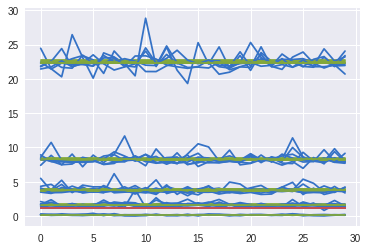

In [28]:
# Doing the same for alpha 
alphas = [1.0, 5.0, 10.0, 20.0, 50.0]
energy_list_alpha = []
differences_list_alpha = []
for alpha in alphas:
    print "Alpha : {}".format(alpha)
    for N in Ns:
        print "Value of N:{}".format(N)
        energies, differences = test_for_n(alpha, N, nb_runs)
        energy_list_alpha.append(energies)
        differences_list_alpha.append(differences)
        print "Average difference :{}".format(np.average(np.asarray(differences)))

# Plotting the differences between analytical and numerical results 

In [36]:
energy_list = np.asarray(energy_list)
print energy_list.shape

(6, 30)


In [53]:
energy_analytic_list = np.ones(nb_runs)*compute_energy_analytic(5.0, sigma, m)

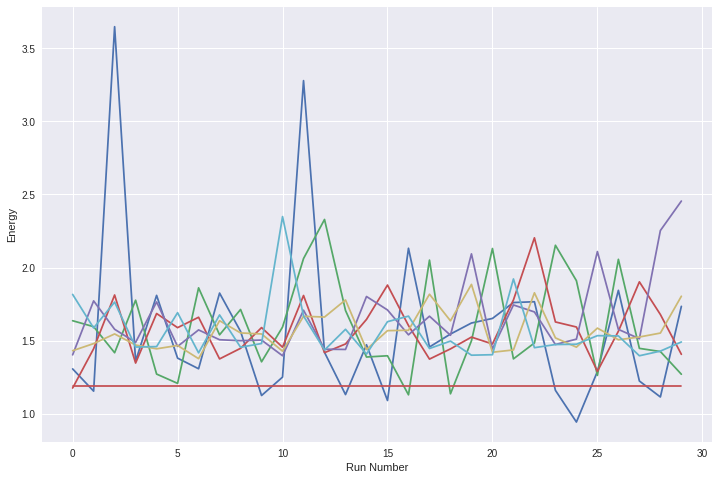

In [67]:
plt.figure(figsize = (12,8))
plt.ylabel('Energy')
plt.xlabel('Run Number')
plt.plot(np.arange(nb_runs), energy_list.transpose(), np.arange(nb_runs), energy_analytic_list, 'r')

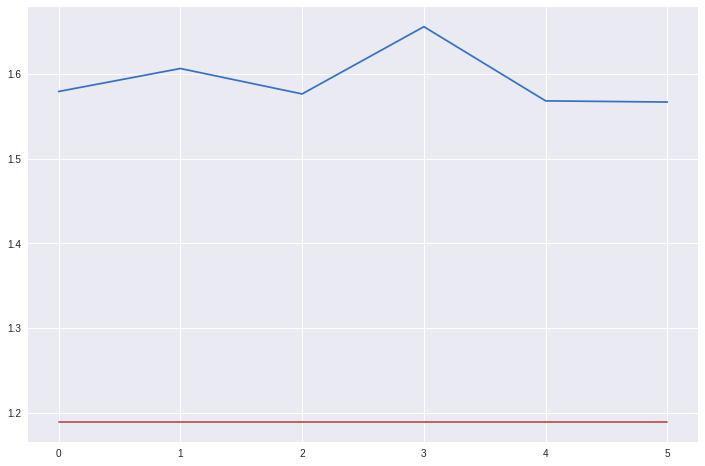

In [64]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(Ns)), np.average(energy_list, axis = 1), 'b', np.arange(len(Ns)), np.ones(len(Ns))*compute_energy_analytic(5.0, sigma, m), 'r')

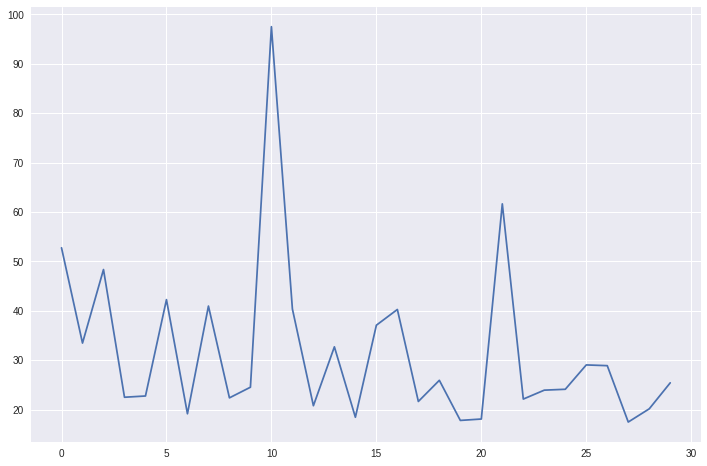

In [74]:
en_alpha_5 = compute_energy_analytic(5.0, sigma, m)
plt.figure(figsize = (12,8))
plt.plot(np.asarray(differences_list[5]).transpose())

(array([ 11.,  66.,  64.,  24.,  10.,   3.,   0.,   0.,   1.,   1.]),
 array([ 0.94388207,  1.21423039,  1.48457871,  1.75492703,  2.02527535,
         2.29562367,  2.56597199,  2.83632031,  3.10666864,  3.37701696,
         3.64736528]),
 <a list of 10 Patch objects>)

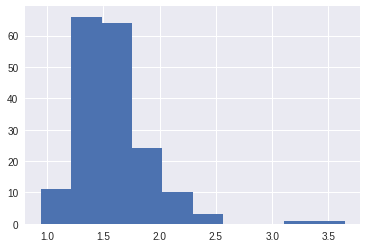

In [78]:
plt.hist(energy_list.reshape(nb_runs*len(Ns)))

In [81]:
print np.average(energy_list)
print en_alpha_5

1.59205665753
1.18918634457


In [60]:
test = np.arange(10).reshape(2,5)
print test

[[0 1 2 3 4]
 [5 6 7 8 9]]


In [62]:
print np.average(test, axis = 1)

[ 2.  7.]


In [85]:
energy_list_alpha_2 = np.asarray(energy_list_alpha)
energy_list_alpha_2 = np.reshape(energy_list_alpha_2, (len(alphas), len(Ns), nb_runs))

In [86]:
energy_list_alpha_2.shape

(5, 6, 30)

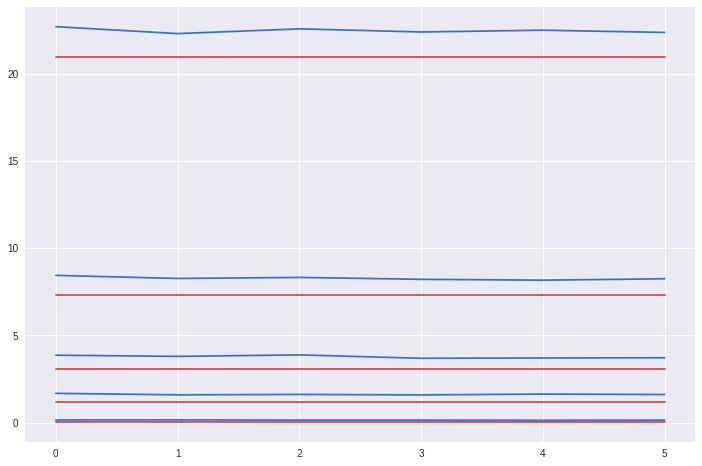

In [99]:
plt.figure(figsize = (12,8))
for i in range(len(alphas)):
    plt.plot(np.arange(len(Ns)), np.average(energy_list_alpha_2[i], axis = 1), 'b', np.arange(len(Ns)), np.ones(len(Ns))*compute_energy_analytic(alphas[i], sigma, m), 'r')

([<matplotlib.axis.XTick at 0x7f669746b450>,
 <a list of 6 Text xticklabel objects>)

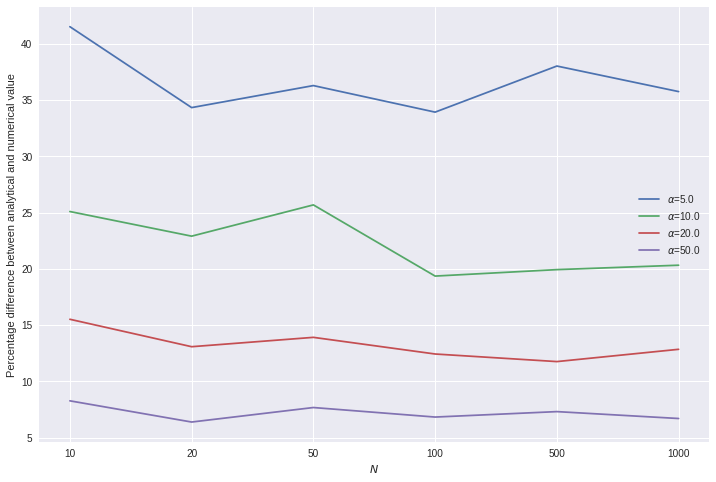

In [146]:
plt.figure(figsize=(12,8))
plt.xlabel(r'$N$')
plt.ylabel("Percentage difference between analytical and numerical value")
for i in range(1,len(alphas)):
    en_an = compute_energy_analytic(alphas[i], sigma, m)
    plt.plot(np.arange(len(Ns)), ((np.average(energy_list_alpha_2[i], axis=1) - en_an)/en_an)* 100, label = r'$\alpha$='+ "{}".format(alphas[i]))
plt.legend()
plt.xticks(np.arange(len(Ns)), Ns)

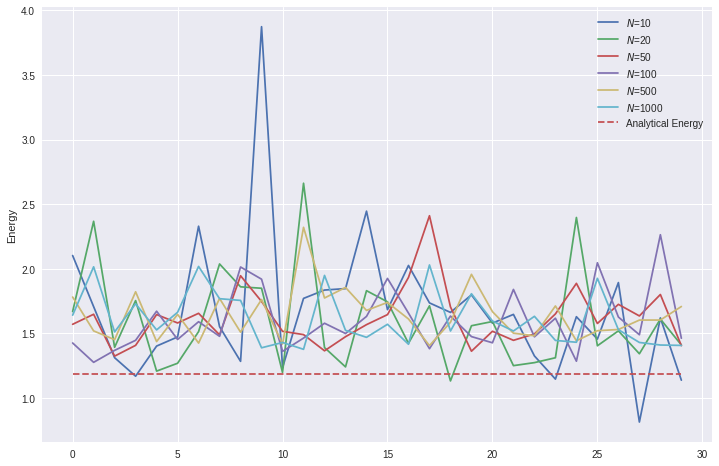

In [151]:
plt.figure(figsize = (12,8))
plt.ylabel('Energy')
for i in range(len(Ns)):
    plt.plot(np.arange(nb_runs), energy_list_alpha_2[1][i], label = r"$N$=" + "{}".format(Ns[i]))
plt.plot(np.arange(nb_runs), np.ones(nb_runs)*compute_energy_analytic(alphas[1], sigma, m), 'r--', label = "Analytical Energy")
plt.legend()

In [102]:
print compute_energy_analytic(alphas[-1], sigma, m)

20.9550700051


In [122]:
for i in range(len(alphas)-1):
    print ((np.average(energy_list_alpha_2[i], axis=1) - compute_energy_analytic(alphas[i], sigma, m))/compute_energy_analytic(alphas[i], sigma, m))*100

[ 295.66465317  307.46037407  279.02641432  280.48373535  244.80789494
  278.14186414]
[ 41.51788804  34.32585454  36.28308211  33.92297253  38.01974986
  35.74889406]
[ 25.08764721  22.89819105  25.67708538  19.3501475   19.92358785
  20.31603217]
[ 15.51029264  13.07205254  13.90331378  12.42297761  11.74919652
  12.84046692]


In [115]:
compute_energy_analytic(alphas[0], sigma, m)

0.03960193151122203

In [117]:
(compute_alpha_J(sigma,m) - alphas[0])**2

0.22629651700264697

In [118]:
m

0.67419986246324204

In [119]:
sigma

0.5

In [120]:
alphas[0]

1.0

In [148]:
energy_list_alpha_2[1][0]

array([ 2.10233862,  1.70690508,  1.31171986,  1.16857092,  1.40171239,
        1.47245905,  2.3292978 ,  1.55164822,  1.283653  ,  3.8735189 ,
        1.23483041,  1.77062766,  1.83537947,  1.84644147,  2.44579636,
        1.68352931,  2.02560704,  1.73589643,  1.66227856,  1.79795681,
        1.57923988,  1.64682515,  1.32538659,  1.14613012,  1.62891343,
        1.4558742 ,  1.89307488,  0.81388478,  1.61999051,  1.13785513])